In [1]:
#!pip install pandas matplotlib

# 2:2 internode

```
export DOCKER_API_VERSION=1.39

curl -X POST http://localhost:8000/generate_traffic -H "Content-Type: application/json" -d '{"dst_ip": "10.10.1.2", "dst_port": 8080, "protocol": "udp", "packet_count": 10000}'

curl -X POST http://localhost:8001/generate_traffic -H "Content-Type: application/json" -d '{"dst_ip": "10.10.1.2", "dst_port": 8081, "protocol": "udp", "packet_count": 10000}'

 curl -X POST http://localhost:8000/send -H "Content-Type: application/json" -d '{"pcap_file": "generated_packets_udp_10000.pcap", "rate": "10GiB", "interface": "eth0"}'

 curl -X POST http://localhost:8001/send -H "Content-Type: application/json" -d '{"pcap_file": "generated_packets_udp_10000.pcap", "rate": "10GiB", "interface": "eth0"}'

docker run -d -p 0.0.0.0:8081:80/udp isukim/ee817_target
docker run -d -p 8001:8000 isukim/ee817_traffic
```

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import pandas as pd
import numpy as np

def calculate_throughput(df, container_name=None):
    # Create a copy of the dataframe
    df = df.copy()
    
    # Convert timestamp to seconds from nanoseconds
    df = df[(df['Length'] == 1514) | (df['Length'] == 1500)]
    df['Timestamp_sec'] = df['Timestamp'] / 1e9
    
    # Filter for specific container if provided
    if container_name:
        df = df[df['ContainerName'] == container_name]
    
    # Return zeros if we can't calculate meaningful results
    if df.empty:
        return {'bytes_per_sec': 0, 'kilobytes_per_sec': 0, 'megabytes_per_sec': 0, 
                'total_duration_seconds': 0, 'total_bytes': 0}
    
    # Calculate metrics
    start_time = df['Timestamp_sec'].min()
    end_time = df['Timestamp_sec'].max()
    total_duration = end_time - start_time
    total_bytes = df['Length'].sum()
    
    # Calculate bytes per second
    bytes_per_sec = total_bytes / total_duration if total_duration > 0 else 0
    
    return {
        'bytes_per_sec': bytes_per_sec,
        'kilobytes_per_sec': bytes_per_sec / 1024,
        'megabytes_per_sec': bytes_per_sec / (1024 * 1024),
        'total_duration_seconds': total_duration,
        'total_bytes': total_bytes
    }

# If you want to see throughput over time intervals (e.g., per second)
def calculate_interval_throughput(df, interval_seconds=1, container_name=None):
    df = df.copy()
    
    # Convert timestamp to seconds and filter if needed
    df['Timestamp_sec'] = df['Timestamp'] / 1e9
    if container_name:
        df = df[df['ContainerName'] == container_name]
    
    # Create time bins
    df['time_bin'] = pd.cut(df['Timestamp_sec'], 
                           bins=np.arange(df['Timestamp_sec'].min(),
                                        df['Timestamp_sec'].max() + interval_seconds,
                                        interval_seconds))
    
    # Calculate throughput for each bin
    throughput = df.groupby('time_bin')['Length'].sum() / interval_seconds
    return throughput

In [4]:
def print_container_stats(container_name, direction, df):
    """
    Print formatted container throughput statistics.
    
    Args:
        container_name (str): Name of the container
        direction (str): Traffic direction (e.g., 'tc_egress', 'skb_ingress')
        df (pd.DataFrame): DataFrame containing network statistics
    """
    data = df[
              (df['Hook'] == direction) & 
              (df['ContainerName'] == container_name)]
    
    container_results = calculate_throughput(data, container_name)
    interval_results = calculate_interval_throughput(data, 
                                                   interval_seconds=1, 
                                                   container_name=container_name)
    
    print(f"\nContainer Network Analysis")
    print("=" * 50)
    
    print(f"\nContainer Information:")
    print("-" * 50)
    print(f"Name:           {container_name}")
    print(f"Direction:      {direction}")
    
    print(f"\nAggregate Throughput:")
    print("-" * 50)
    print(f"Bytes/second:   {container_results['bytes_per_sec']:>15,.2f} B/s")
    print(f"Kilobytes/sec:  {container_results['kilobytes_per_sec']:>15,.2f} KB/s")
    print(f"Megabytes/sec:  {container_results['megabytes_per_sec']:>15,.2f} MB/s")
    
    print(f"\nTransfer Summary:")
    print("-" * 50)
    print(f"Total Duration: {container_results['total_duration_seconds']:>15,.2f} seconds")
    print(f"Total Bytes:    {container_results['total_bytes']:>15,d} bytes")
    
    print(f"\nThroughput Time Series (per second):")
    print("-" * 50)
    
    # Format the time series data, handling Interval objects
    for interval, throughput in interval_results.items():
        # Extract the start time from the interval object
        if hasattr(interval, 'left'):
            # If it's an Interval object, use the left boundary
            time_point = interval.left
        else:
            # If it's already a number, use it directly
            time_point = interval
            
        print(f"Second {int(time_point):3d}: {throughput:>15,.2f} B/s")

def print_multi_container_comparison(containers_data):
    """
    Print a comparison of multiple containers' throughput statistics.
    
    Args:
        containers_data (list): List of dictionaries containing container results
    """
    print("\nContainer Throughput Comparison")
    print("=" * 50)
    
    # Print header
    print("\nAggregate Statistics:")
    print("-" * 50)
    
    # Print each container's stats
    for container in containers_data:
        name = container['container_name']
        results = container['results']
        
        print(f"\n{name}")
        print(f"  Throughput:      {results['megabytes_per_sec']:>8,.2f} MB/s")
        print(f"  Total Transfer:  {results['total_bytes']:>8,d} bytes")
        print(f"  Duration:        {results['total_duration_seconds']:>8,.2f} seconds")

In [5]:
import pandas as pd
import numpy as np

def analyze_container_packet_latencies(df, container_names):
    """
    Analyze packet latencies across different stages of packet processing for specific containers.
    
    Args:
        df (pd.DataFrame): DataFrame with columns:
            - PacketHash
            - Timestamp
            - Hook (tc_egress, skb_ingress, skb_egress)
            - ContainerName
        container_names (tuple): Tuple of container names to analyze (without prefixes)
            
    Returns:
        dict: Dictionary where keys are container names and values are tuples of
             (detailed_latencies, summary_stats)
    """
    results = {}
    
    for container_name in container_names:
        # Filter for both container:/ and host:/ prefixes
        container_df = df[
            (df['ContainerName'] == f'container:/{container_name}') |
            (df['ContainerName'] == f'host:/{container_name}')
        ]
        
        # Skip if no data for this container
        if len(container_df) == 0:
            results[container_name] = (pd.DataFrame(), {
                'avg_tc_to_ingress_ns': np.nan,
                'avg_ingress_to_egress_ns': np.nan,
                'avg_end_to_end_ns': np.nan,
                'total_packets_analyzed': 0
            })
            continue
            
        # Create a results container for this container's packet latencies
        container_results = []
        
        # Group by PacketHash to analyze each packet's journey
        for packet_hash, group in container_df.groupby('PacketHash'):
            # Sort by timestamp to ensure correct order
            group = group.sort_values('Timestamp')
            
            # Initialize latency values
            tc_to_ingress = np.nan
            ingress_to_egress = np.nan
            end_to_end = np.nan
            
            # Find timestamps for each stage
            tc_egress_time = group[group['Hook'] == 'tc_egress']['Timestamp'].iloc[0] if any(group['Hook'] == 'tc_egress') else None
            skb_ingress_time = group[group['Hook'] == 'skb_ingress']['Timestamp'].iloc[0] if any(group['Hook'] == 'skb_ingress') else None
            skb_egress_time = group[group['Hook'] == 'skb_egress']['Timestamp'].iloc[0] if any(group['Hook'] == 'skb_egress') else None
            
            # Calculate latencies if timestamps exist
            if tc_egress_time is not None and skb_ingress_time is not None:
                tc_to_ingress = skb_ingress_time - tc_egress_time
                
            if skb_ingress_time is not None and skb_egress_time is not None:
                ingress_to_egress = skb_egress_time - skb_ingress_time
                
            if tc_egress_time is not None and skb_egress_time is not None:
                end_to_end = skb_egress_time - tc_egress_time
            
            # Store results
            container_results.append({
                'PacketHash': packet_hash,
                'tc_to_ingress_ns': tc_to_ingress,
                'ingress_to_egress_ns': ingress_to_egress,
                'end_to_end_ns': end_to_end
            })
        
        # Create DataFrame with detailed results
        detailed_latencies = pd.DataFrame(container_results)
        
        # Calculate summary statistics
        summary_stats = {
            'avg_tc_to_ingress_ns': detailed_latencies['tc_to_ingress_ns'].mean(),
            'avg_ingress_to_egress_ns': detailed_latencies['ingress_to_egress_ns'].mean(),
            'avg_end_to_end_ns': detailed_latencies['end_to_end_ns'].mean(),
            'total_packets_analyzed': len(detailed_latencies)
        }
        
        # Store results for this container
        results[container_name] = (detailed_latencies, summary_stats)
    
    return results

def print_latency_stats(stats_dict):
    """
    Format and print latency statistics in a clear, readable way.
    Converts nanoseconds to microseconds for better readability.
    
    Args:
        stats_dict (dict): Dictionary containing latency statistics
    """
    print("Network Packet Latency Analysis")
    print("=" * 40)
    print(f"\nLatency Measurements (in microseconds):")
    print("-" * 40)
    print(f"TC Egress → SKB Ingress:    {stats_dict['avg_tc_to_ingress_ns']/1000:>8.2f} μs")
    print(f"SKB Ingress → SKB Egress:   {stats_dict['avg_ingress_to_egress_ns']/1000:>8.2f} μs")
    print(f"End-to-End Latency:         {stats_dict['avg_end_to_end_ns']/1000:>8.2f} μs")
    print("\nSample Size:")
    print("-" * 40)
    print(f"Total Packets Analyzed:     {stats_dict['total_packets_analyzed']:>8,d}")

In [6]:
def print_container_statistics(container_name, df):
    """
    Print detailed network statistics for all traffic directions of a container.
    
    Args:
        container_name (str): Base name of the container (without prefixes)
        df (pd.DataFrame): DataFrame containing network statistics
    """
    # Define all possible traffic directions and container prefixes
    directions = ['skb_egress', 'skb_ingress', 'xdp_egress', 
                 'xdp_ingress', 'tc_ingress', 'tc_egress']
    prefixes = ['container:/', 'host:/']
    
    def get_throughput(full_container_name, direction):
        data = df[
            (df['Hook'] == direction) & 
            (df['ContainerName'] == full_container_name)
        ]
        if len(data) == 0:
            return None
            
        results = calculate_throughput(data, full_container_name)
        return results
    
    print("Container Network Analysis")
    print("=" * 50)
    
    # Process each prefix (container side and host side)
    for prefix in prefixes:
        full_container_name = f"{prefix}{container_name}"
        
        print(f"\n{prefix.rstrip(':').title()} Network Statistics")
        print("-" * 50)
        print(f"Container Name: {full_container_name}")
        
        # Check each direction
        for direction in directions:
            results = get_throughput(full_container_name, direction)
            
            print(f"\nDirection: {direction}")
            print("-" * 25)
            
            if results is not None and results['total_bytes'] > 0:
                print(f"Throughput:")
                print(f"  Bytes/second:    {results['bytes_per_sec']:>15,.2f} B/s")
                print(f"  Kilobytes/sec:   {results['kilobytes_per_sec']:>15,.2f} KB/s")
                print(f"  Megabytes/sec:   {results['megabytes_per_sec']:>15,.2f} MB/s")
                print(f"\nTransfer Summary:")
                print(f"  Total Duration:  {results['total_duration_seconds']:>15,.2f} seconds")
                print(f"  Total Bytes:     {results['total_bytes']:>15,d} bytes")
            else:
                print(f"Throughput:")
                print(f"  Bytes/second:    {0:>15,.2f} B/s")
                print(f"  Kilobytes/sec:   {0:>15,.2f} KB/s")
                print(f"  Megabytes/sec:   {0:>15,.2f} MB/s")
                print(f"\nTransfer Summary:")
                print(f"  Total Duration:  {0:>15,.2f} seconds")
                print(f"  Total Bytes:     {0:>15,d} bytes")

In [7]:
def print_container_summary(container_name, df):
    """
    Print a concise summary of all traffic directions for a container.
    Shows throughput rates and total bytes for each direction.
    
    Args:
        container_name (str): Base name of the container (without prefixes)
        df (pd.DataFrame): DataFrame containing network statistics
    """
    # Define all possible traffic directions and container prefixes
    directions = ['skb_egress', 'skb_ingress', 'xdp_egress', 
                 'xdp_ingress', 'tc_ingress', 'tc_egress']
    prefixes = ['container:/', 'host:/']
    
    # Function to get throughput for a specific container and direction
    def get_throughput(full_container_name, direction):
        data = df[
            (df['Hook'] == direction) & 
            (df['ContainerName'] == full_container_name)
        ]
        if len(data) == 0:
            return None
            
        results = calculate_throughput(data, full_container_name)
        return results
    
    # Print container name
    print(f"container name = {container_name}")

    if "host" in container_name:
        # Check each direction
        for direction in directions:
            results = get_throughput(container_name, direction)
            if results is not None and results['total_bytes'] > 0:
                print(f"* {direction:<10} {results['megabytes_per_sec']:>8.2f} MB/s "
                      f"({results['kilobytes_per_sec']:,.2f} KB/s) - "
                      f"Total: {results['total_bytes']:,d} bytes")
            else:
                print(f"* {direction:<10} {0:>8.2f} MB/s "
                      f"({0:.2f} KB/s) - "
                      f"Total: 0 bytes")
    else:
        # Process each prefix (container side and host side)
        for prefix in prefixes:
            full_container_name = f"{prefix}{container_name}"
            print(f"\n{prefix.rstrip(':')}_side ({full_container_name})")
            
            # Check each direction
            for direction in directions:
                results = get_throughput(full_container_name, direction)
                if results is not None and results['total_bytes'] > 0:
                    print(f"* {direction:<10} {results['megabytes_per_sec']:>8.2f} MB/s "
                          f"({results['kilobytes_per_sec']:,.2f} KB/s) - "
                          f"Total: {results['total_bytes']:,d} bytes")
                else:
                    print(f"* {direction:<10} {0:>8.2f} MB/s "
                          f"({0:.2f} KB/s) - "
                          f"Total: 0 bytes")

In [8]:
def print_container_statistics(container_name, df):
    """
    Print detailed network statistics for all traffic directions of a container.
    
    Args:
        container_name (str): Base name of the container (without prefixes)
        df (pd.DataFrame): DataFrame containing network statistics
    """
    print("CN= " + container_name)
    # Define all possible traffic directions and container prefixes
    directions = ['skb_egress', 'skb_ingress', 'xdp_egress', 
                 'xdp_ingress', 'tc_ingress', 'tc_egress']
    prefixes = ['container:/', 'host:/']
    
    def get_throughput(full_container_name, direction):
        data = df[
            (df['Hook'] == direction) & 
            (df['ContainerName'] == full_container_name)
        ]
        if len(data) == 0:
            return None
            
        results = calculate_throughput(data, full_container_name)
        return results
    
    print("Container Network Analysis")
    print("=" * 50)

    if "host" in container_name:
        print(f"\n{prefix.rstrip(':').title()} Network Statistics")
        print("-" * 50)
        print(f"Container Name: {container_name}")
        
        # Check each direction
        for direction in directions:
            print(f"\n{prefix.rstrip(':').title()} Network Statistics")
            print("-" * 50)
            
            results = get_throughput(container_name, direction)
            
            print(f"\nDirection: {direction}")
            print("-" * 25)
            
            if results is not None and results['total_bytes'] > 0:
                print(f"Throughput:")
                print(f"  Bytes/second:    {results['bytes_per_sec']:>15,.2f} B/s")
                print(f"  Kilobytes/sec:   {results['kilobytes_per_sec']:>15,.2f} KB/s")
                print(f"  Megabytes/sec:   {results['megabytes_per_sec']:>15,.2f} MB/s")
                print(f"\nTransfer Summary:")
                print(f"  Total Duration:  {results['total_duration_seconds']:>15,.2f} seconds")
                print(f"  Total Bytes:     {results['total_bytes']:>15,d} bytes")
            else:
                print(f"Throughput:")
                print(f"  Bytes/second:    {0:>15,.2f} B/s")
                print(f"  Kilobytes/sec:   {0:>15,.2f} KB/s")
                print(f"  Megabytes/sec:   {0:>15,.2f} MB/s")
                print(f"\nTransfer Summary:")
                print(f"  Total Duration:  {0:>15,.2f} seconds")
                print(f"  Total Bytes:     {0:>15,d} bytes")        
    else:        
        for prefix in prefixes:
            full_container_name = f"{prefix}{container_name}"
            
            print(f"\n{prefix.rstrip(':').title()} Network Statistics")
            print("-" * 50)
            print(f"Container Name: {full_container_name}")
            
            # Check each direction
            for direction in directions:
                results = get_throughput(full_container_name, direction)
                
                print(f"\nDirection: {direction}")
                print("-" * 25)
                
                if results is not None and results['total_bytes'] > 0:
                    print(f"Throughput:")
                    print(f"  Bytes/second:    {results['bytes_per_sec']:>15,.2f} B/s")
                    print(f"  Kilobytes/sec:   {results['kilobytes_per_sec']:>15,.2f} KB/s")
                    print(f"  Megabytes/sec:   {results['megabytes_per_sec']:>15,.2f} MB/s")
                    print(f"\nTransfer Summary:")
                    print(f"  Total Duration:  {results['total_duration_seconds']:>15,.2f} seconds")
                    print(f"  Total Bytes:     {results['total_bytes']:>15,d} bytes")
                else:
                    print(f"Throughput:")
                    print(f"  Bytes/second:    {0:>15,.2f} B/s")
                    print(f"  Kilobytes/sec:   {0:>15,.2f} KB/s")
                    print(f"  Megabytes/sec:   {0:>15,.2f} MB/s")
                    print(f"\nTransfer Summary:")
                    print(f"  Total Duration:  {0:>15,.2f} seconds")
                    print(f"  Total Bytes:     {0:>15,d} bytes")

- src_c1 = 619.21 Mbps -> vigilant_bhaskara
- src_c2 = 600.26 Mbps -> loving_dijkstra

- dst_c1 = trusting_jemison
- dst_c2 = unruffled_davinci

# =============== SRC ===============

In [9]:
import re


def generate_traffic_heatmap(df_src, df_dst, direction):
    def get_df_stats(df):
        # get container names
        containers = df["ContainerName"].unique()
        containers = [str(x) for x in containers]
        containers = [x.replace("container:/", "") for x in containers]
        containers = [x.replace("host:/", "") for x in containers]
        containers = [x for x in containers if re.search(r'\d[sd]', x) and "host" not in x]
        
        containers = list(set(containers))
        print(f"Containers identified: {containers}")
        # Function to get throughput for a specific container and direction
        def get_throughput(full_container_name, direction, df):
            data = df[
                (df['Hook'] == direction) & 
                (df['ContainerName'] == full_container_name)
            ]
            if len(data) == 0:
                return None
                
            results = calculate_throughput(data, full_container_name)
            return results
    
        directions = ['skb_egress', 'skb_ingress', 'xdp_egress', 
                     'xdp_ingress', 'tc_ingress', 'tc_egress']
        prefixes = ['container:/', 'host:/']
    
        stats = {}
        
        for container_name in containers:           
            # Process each prefix (container side and host side)
            for prefix in prefixes:
                full_container_name = f"{prefix}{container_name}"                
                direction_stats = {}
                # Check each direction
                for direction in directions:
                    results = get_throughput(full_container_name, direction, df)
                    if results is not None and results['total_bytes'] > 0:
                        direction_stats[direction] = results['megabytes_per_sec']
                    else:
                        direction_stats[direction] = 0
    
                stats[full_container_name] = direction_stats

        return containers, stats
    print("[+] Processing src")
    src_containers, src_stats = get_df_stats(df_src)
    print("[+] Processing dst")
    dst_containers, dst_stats = get_df_stats(df_dst)
    
    src_bandwidths = {}
    
    dst_bandwidths_in = {}
    dst_bandwidths_out = {}
    
    for container in src_stats:
        if "container" in container:
            src_bandwidths[int(container.replace("container:/", "").replace("s", ""))] = src_stats[container]["tc_egress"]

    for container in dst_stats:
        if "container" in container:
            dst_bandwidths_in[int(container.replace("container:/", "").replace("d", ""))] = dst_stats[container]["skb_ingress"]
        if "host:/" in container:
            dst_bandwidths_out[int(container.replace("host:/", "").replace("d", ""))] = dst_stats[container]["tc_egress"]
            
    print(src_bandwidths)
    print(dst_bandwidths_in)
    print(dst_bandwidths_out)

    def plot_bandwidth_comparison(src_data, dst_data_in, dst_data_out):
        plt.figure(figsize=(10, 6))
        
        # Create ordered lists from dictionaries
        containers = sorted(src_data.keys())
        src_bandwidths = [src_data[i] for i in containers]
        dst_bandwidths_in = [dst_data_in[i] for i in containers]
        dst_bandwidths_out = [dst_data_out[i] for i in containers]
        
        x = np.arange(len(containers))
        
        # Plot both lines
        plt.plot(x, src_bandwidths, 'b-o', label='Source')
        plt.plot(x, dst_bandwidths_in, 'r-o', label='Destination (Inside Container)')
        plt.plot(x, dst_bandwidths_out, 'r-o', label='Destination (Outside Container)')

        
        plt.ylabel('Bandwidth (MB/s)')
        plt.title('Source vs Destination Bandwidth')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        
        # Set x-ticks and labels
        ax = plt.gca()
        ax.set_xticks(x)
        
        # Create multi-line labels
        labels = [f'{i}s\n{i}d' for i in containers]
        ax.set_xticklabels(labels)
        
        # Add "Container" label
        ax.set_xlabel("Container")
        
        plt.tight_layout()
        plt.show()

    plot_bandwidth_comparison(src_bandwidths, dst_bandwidths_in, dst_bandwidths_out)

In [10]:
def generate_saturation(df_srcs, df_dsts):
    cnt_src_total = []
    cnt_dst_total_in = []
    cnt_dst_total_out = []
    host_src_total = []
    host_dst_total = []
    
    for i in range(len(df_dsts)):
        df_src = df_srcs[i]
        df_dst = df_dsts[i]

        def get_container_names(df):
            containers = df["ContainerName"].unique()
            containers = [str(x) for x in containers]
            containers = [x.replace("container:/", "") for x in containers]
            containers = [x.replace("host:/", "") for x in containers]
            containers = [x for x in containers if re.search(r'\d[sd]', x) and "host" not in x]
            containers = list(set(containers))
            return containers

        def get_throughput(full_container_name, direction, df):
            data = df[
                (df['Hook'] == direction) & 
                (df['ContainerName'] == full_container_name)
            ]
            if len(data) == 0:
                return None
                
            results = calculate_throughput(data, full_container_name)
            return results
        
        def get_container_bandwidth(containers, df):        
            directions = ['skb_egress', 'skb_ingress', 'xdp_egress', 
                         'xdp_ingress', 'tc_ingress', 'tc_egress']
            prefixes = ['container:/', 'host:/']
            stats = {}
            
            for container_name in containers:           
                # Process each prefix (container side and host side)
                for prefix in prefixes:
                    full_container_name = f"{prefix}{container_name}"                
                    direction_stats = {}
                    # Check each direction
                    for direction in directions:
                        results = get_throughput(full_container_name, direction, df)
                        if results is not None and results['total_bytes'] > 0:
                            direction_stats[direction] = results['megabytes_per_sec']
                        else:
                            direction_stats[direction] = 0
        
                    stats[full_container_name] = direction_stats
            return stats
    
        src_containers = get_container_names(df_src)
        dst_containers = get_container_names(df_dst)
        
        src_stats = get_container_bandwidth(src_containers, df_src)
        dst_stats = get_container_bandwidth(dst_containers, df_dst)
        
        src_bandwidths = {}
        dst_bandwidths_in = {}
        dst_bandwidths_out = {}

        for container in src_stats:
            if "container" in container:
                src_bandwidths[int(container.replace("container:/", "").replace("s", ""))] = src_stats[container]["tc_egress"]
    
        for container in dst_stats:
            if "container" in container:
                dst_bandwidths_in[int(container.replace("container:/", "").replace("d", ""))] = dst_stats[container]["skb_egress"]
            if "host:/" in container:
                dst_bandwidths_out[int(container.replace("host:/", "").replace("d", ""))] = dst_stats[container]["tc_egress"]
        
        print(f"==== src:{len(src_containers)} -> dst:{len(dst_containers)} ====")
        cnt_src_avg = (sum([src_bandwidths[x] for x in src_bandwidths]))/len(src_bandwidths)
        cnt_dst_avg_in = (sum([dst_bandwidths_in[x] for x in dst_bandwidths_in]))/len(dst_bandwidths_in)
        cnt_dst_avg_out = (sum([dst_bandwidths_out[x] for x in dst_bandwidths_out]))/len(dst_bandwidths_out)
        cnt_src_sum = (sum([src_bandwidths[x] for x in src_bandwidths]))
        cnt_dst_sum_in = (sum([dst_bandwidths_in[x] for x in dst_bandwidths_in]))
        cnt_dst_sum_out = (sum([dst_bandwidths_out[x] for x in dst_bandwidths_out]))
        host_src = get_throughput("host_nic", "tc_egress" , df_src)["megabytes_per_sec"]
        host_dst = get_throughput("host_nic", "tc_ingress" , df_dst)["megabytes_per_sec"]
        
        print(f"Average SRC in container throughput = avg {cnt_src_avg} MB/s, sum {cnt_src_sum} MB/s")
        print(f"Average SRC host throughput = {host_src} MB/s")
        print(f"Average DST in container throughput = avg {cnt_dst_avg_in} MB/s, sum {cnt_dst_sum_in} MB/s")
        print(f"Average DST out container throughput = avg {cnt_dst_avg_out} MB/s, sum {cnt_dst_sum_out} MB/s")
        print(f"Average DST host throughput = {host_dst} MB/s")

        cnt_src_total.append(cnt_src_sum)
        cnt_dst_total_in.append(cnt_dst_sum_in)
        cnt_dst_total_out.append(cnt_dst_sum_out)
        host_src_total.append(host_src)
        host_dst_total.append(host_dst)

    return cnt_src_total, cnt_dst_total_in, cnt_dst_total_out, host_src_total, host_dst_total
        

In [11]:
import re
import multiprocessing as mp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import partial

def generate_traffic_heatmap(df_src, df_dst, direction):
    def preprocess_dataframe(df):
        # Pre-filter the dataframe once
        df['ContainerName'] = df['ContainerName'].astype(str)
        df['is_container'] = df['ContainerName'].str.contains(r'container:/\d+[sd]')
        df['is_host'] = df['ContainerName'].str.contains(r'host:/\d+[sd]')
        df['container_number'] = df['ContainerName'].str.extract(r'(\d+)[sd]').astype(int)
        return df[df['is_container'] | df['is_host']]

    def get_throughput(df_group, container_type, container_num, hook):
        mask = (
            (df_group['ContainerName'].str.contains(f'{container_type}/{container_num}')) &
            (df_group['Hook'] == hook)
        )
        data = df_group[mask]
        if len(data) == 0:
            return 0
        
        return calculate_throughput(data, f"{container_type}/{container_num}")['megabytes_per_sec']

    def process_container(container_num, df_src_group, df_dst_group):
        # Process source containers
        src_bandwidth = get_throughput(df_src_group, 'container:/', f"{container_num}s", 'tc_egress')
        
        # Process destination containers
        dst_bandwidth_in = get_throughput(df_dst_group, 'container:/', f"{container_num}d", 'skb_ingress')
        dst_bandwidth_out = get_throughput(df_dst_group, 'host:/', f"{container_num}d", 'tc_egress')
        
        return {
            'num': container_num,
            'src': src_bandwidth,
            'dst_in': dst_bandwidth_in,
            'dst_out': dst_bandwidth_out
        }

    # Preprocess dataframes
    df_src = preprocess_dataframe(df_src)
    df_dst = preprocess_dataframe(df_dst)

    # Get unique container numbers
    container_numbers = pd.concat([
        df_src['container_number'],
        df_dst['container_number']
    ]).unique()
    container_numbers.sort()

    # Create a partial function with the dataframes
    process_container_partial = partial(process_container, 
                                     df_src_group=df_src,
                                     df_dst_group=df_dst)

    # Initialize the multiprocessing pool with all available cores
    num_cores = mp.cpu_count()
    print(f"Using {num_cores} CPU cores")
    
    # Using 'spawn' instead of 'fork' for better notebook compatibility
    ctx = mp.get_context('spawn')
    
    # Process containers in parallel using all CPU cores
    with ctx.Pool(processes=num_cores) as pool:
        results_list = pool.map(process_container_partial, container_numbers)

    # Organize results
    results = {
        'src': {},
        'dst_in': {},
        'dst_out': {}
    }
    
    for result in results_list:
        container_num = result['num']
        results['src'][container_num] = result['src']
        results['dst_in'][container_num] = result['dst_in']
        results['dst_out'][container_num] = result['dst_out']

    def plot_bandwidth_comparison(results):
        plt.figure(figsize=(10, 6))
        
        containers = sorted(results['src'].keys())
        x = np.arange(len(containers))
        
        plt.plot(x, [results['src'][i] for i in containers], 'b-o', label='Source', linewidth=2)
        plt.plot(x, [results['dst_in'][i] for i in containers], 'r-o', label='Destination (Inside Container)', linewidth=2)
        plt.plot(x, [results['dst_out'][i] for i in containers], 'g-o', label='Destination (Outside Container)', linewidth=2)
        
        plt.ylabel('Bandwidth (MB/s)', fontsize=12)
        plt.title('Source vs Destination Bandwidth', fontsize=14, pad=20)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend(fontsize=10)
        
        ax = plt.gca()
        ax.set_xticks(x)
        ax.set_xticklabels([f'{i}s\n{i}d' for i in containers], fontsize=10)
        ax.set_xlabel("Container", fontsize=12)
        
        plt.tight_layout()
        plt.show()

    plot_bandwidth_comparison(results)

In [77]:
def generate_saturation_2(df_srcs, df_dsts):
    cnt_src_total = []
    cnt_dst_total_in = []
    cnt_dst_total_out = []
    host_src_total = []
    host_dst_total = []
    
    for df_src, df_dst in zip(df_srcs, df_dsts):
        # Pre-calculate common string operations
        df_src['clean_name'] = df_src['ContainerName'].astype(str).replace({
            'container:/': '', 'host:/': ''
        }, regex=True)
        df_dst['clean_name'] = df_dst['ContainerName'].astype(str).replace({
            'container:/': '', 'host:/': ''
        }, regex=True)
        
        # Create container masks once
        src_container_mask = (df_src['ContainerName'].str.contains(r'container:/\d+s', regex=True)) & \
                           (df_src['Hook'] == 'tc_egress')
        dst_container_in_mask = (df_dst['ContainerName'].str.contains(r'container:/\d+d', regex=True)) & \
                              (df_dst['Hook'] == 'skb_egress')
        dst_container_out_mask = (df_dst['ContainerName'].str.contains(r'host:/\d+d', regex=True)) & \
                               (df_dst['Hook'] == 'tc_egress')
        
        # Calculate throughputs in batches
        src_data = df_src[src_container_mask].groupby('ContainerName').apply(
            lambda x: calculate_throughput(x, x.name)['megabytes_per_sec']
        )
        dst_in_data = df_dst[dst_container_in_mask].groupby('ContainerName').apply(
            lambda x: calculate_throughput(x, x.name)['megabytes_per_sec']
        )
        dst_out_data = df_dst[dst_container_out_mask].groupby('ContainerName').apply(
            lambda x: calculate_throughput(x, x.name)['megabytes_per_sec']
        )
        
        # Extract container numbers and create dictionaries
        src_bandwidths = {
            int(name.split('/')[-1].replace('s', '')): val 
            for name, val in src_data.items()
        }
        dst_bandwidths_in = {
            int(name.split('/')[-1].replace('d', '')): val 
            for name, val in dst_in_data.items()
        }
        dst_bandwidths_out = {
            int(name.split('/')[-1].replace('d', '')): val 
            for name, val in dst_out_data.items()
        }
        
        # Calculate host throughput
        host_src = calculate_throughput(
            df_src[df_src['ContainerName'] == 'host_nic'][df_src['Hook'] == 'tc_egress'],
            'host_nic'
        )['megabytes_per_sec']
        
        host_dst = calculate_throughput(
            df_dst[df_dst['ContainerName'] == 'host_nic'][df_dst['Hook'] == 'tc_ingress'],
            'host_nic'
        )['megabytes_per_sec']
        
        # Calculate sums
        cnt_src_sum = sum(src_bandwidths.values())
        cnt_dst_sum_in = sum(dst_bandwidths_in.values())
        cnt_dst_sum_out = sum(dst_bandwidths_out.values())
        
        # Calculate averages for printing
        cnt_src_avg = cnt_src_sum / len(src_bandwidths) if src_bandwidths else 0
        cnt_dst_avg_in = cnt_dst_sum_in / len(dst_bandwidths_in) if dst_bandwidths_in else 0
        cnt_dst_avg_out = cnt_dst_sum_out / len(dst_bandwidths_out) if dst_bandwidths_out else 0
        
        # Print statistics
        print(f"==== src:{len(src_bandwidths)} -> dst:{len(dst_bandwidths_in)} ====")
        print(f"Average SRC in container throughput = avg {cnt_src_avg:.2f} MB/s, sum {cnt_src_sum:.2f} MB/s")
        print(f"Average SRC host throughput = {host_src:.2f} MB/s")
        print(f"Average DST in container throughput = avg {cnt_dst_avg_in:.2f} MB/s, sum {cnt_dst_sum_in:.2f} MB/s")
        print(f"Average DST out container throughput = avg {cnt_dst_avg_out:.2f} MB/s, sum {cnt_dst_sum_out:.2f} MB/s")
        print(f"Average DST host throughput = {host_dst:.2f} MB/s")
        
        # Append to totals
        cnt_src_total.append(cnt_src_avg)
        cnt_dst_total_in.append(cnt_dst_avg_in)
        cnt_dst_total_out.append(cnt_dst_avg_out)
        host_src_total.append(host_src)
        host_dst_total.append(host_dst)
    
    return cnt_src_total, cnt_dst_total_in, cnt_dst_total_out, host_src_total, host_dst_total

In [82]:
def generate_saturation_3(df_srcs, df_dsts):
    cnt_src_total = []
    cnt_dst_total_in = []
    cnt_dst_total_out = []
    host_src_total = []
    host_dst_total = []
    
    for df_src, df_dst in zip(df_srcs, df_dsts):
        # Pre-calculate common string operations
        df_src['clean_name'] = df_src['ContainerName'].astype(str).replace({
            'container:/': '', 'host:/': ''
        }, regex=True)
        df_dst['clean_name'] = df_dst['ContainerName'].astype(str).replace({
            'container:/': '', 'host:/': ''
        }, regex=True)
        
        # Create container masks once
        src_container_mask = (df_src['ContainerName'].str.contains(r'container:/\d+s', regex=True)) & \
                           (df_src['Hook'] == 'tc_egress')
        dst_container_in_mask = (df_dst['ContainerName'].str.contains(r'container:/\d+d', regex=True)) & \
                              (df_dst['Hook'] == 'skb_egress')
        dst_container_out_mask = (df_dst['ContainerName'].str.contains(r'host:/\d+d', regex=True)) & \
                               (df_dst['Hook'] == 'tc_egress')
        
        # Calculate throughputs in batches
        src_data = df_src[src_container_mask].groupby('ContainerName').apply(
            lambda x: calculate_throughput(x, x.name)['megabytes_per_sec']
        )
        dst_in_data = df_dst[dst_container_in_mask].groupby('ContainerName').apply(
            lambda x: calculate_throughput(x, x.name)['megabytes_per_sec']
        )
        dst_out_data = df_dst[dst_container_out_mask].groupby('ContainerName').apply(
            lambda x: calculate_throughput(x, x.name)['megabytes_per_sec']
        )
        
        # Extract container numbers and create dictionaries
        src_bandwidths = {
            int(name.split('/')[-1].replace('s', '')): val 
            for name, val in src_data.items()
        }
        dst_bandwidths_in = {
            int(name.split('/')[-1].replace('d', '')): val 
            for name, val in dst_in_data.items()
        }
        dst_bandwidths_out = {
            int(name.split('/')[-1].replace('d', '')): val 
            for name, val in dst_out_data.items()
        }
        
        # Calculate host throughput
        host_src = calculate_throughput(
            df_src[df_src['ContainerName'] == 'host_nic'][df_src['Hook'] == 'tc_egress'],
            'host_nic'
        )['megabytes_per_sec']
        
        host_dst = calculate_throughput(
            df_dst[df_dst['ContainerName'] == 'host_nic'][df_dst['Hook'] == 'tc_ingress'],
            'host_nic'
        )['megabytes_per_sec']
        
        # Calculate sums
        cnt_src_sum = sum(src_bandwidths.values())
        cnt_dst_sum_in = sum(dst_bandwidths_in.values())
        cnt_dst_sum_out = sum(dst_bandwidths_out.values())
        
        # Calculate averages for printing
        cnt_src_avg = cnt_src_sum / len(src_bandwidths) if src_bandwidths else 0
        cnt_dst_avg_in = cnt_dst_sum_in / len(dst_bandwidths_in) if dst_bandwidths_in else 0
        cnt_dst_avg_out = cnt_dst_sum_out / len(dst_bandwidths_out) if dst_bandwidths_out else 0
        
        # Print statistics
        print(f"==== src:{len(src_bandwidths)} -> dst:{len(dst_bandwidths_in)} ====")
        print(f"Average SRC in container throughput = avg {cnt_src_avg:.2f} MB/s, sum {cnt_src_sum:.2f} MB/s")
        print(f"Average SRC host throughput = {host_src:.2f} MB/s")
        print(f"Average DST in container throughput = avg {cnt_dst_avg_in:.2f} MB/s, sum {cnt_dst_sum_in:.2f} MB/s")
        print(f"Average DST out container throughput = avg {cnt_dst_avg_out:.2f} MB/s, sum {cnt_dst_sum_out:.2f} MB/s")
        print(f"Average DST host throughput = {host_dst:.2f} MB/s")
        
        # Append to totals
        cnt_src_total.append(cnt_src_sum)
        cnt_dst_total_in.append(cnt_dst_sum_in)
        cnt_dst_total_out.append(cnt_dst_sum_out)
        host_src_total.append(host_src)
        host_dst_total.append(host_dst)
    
    return cnt_src_total, cnt_dst_total_in, cnt_dst_total_out, host_src_total, host_dst_total

In [58]:
#!wget sng01.isucloud.net:8088/2_64_to_64_src.csv -O data/inter_10/2_64_to_64_src.csv
#!wget sng01.isucloud.net:8088/2_64_to_64_dst.csv -O data/inter_10/2_64_to_64_dst.csv

!wget sng01.isucloud.net:8088/2_32_to_32_src.csv -O data/inter_10/2_32_to_32_src.csv
!wget sng01.isucloud.net:8088/2_32_to_32_dst.csv -O data/inter_10/2_32_to_32_dst.csv

!wget sng01.isucloud.net:8088/2_16_to_16_src.csv -O data/inter_10/2_16_to_16_src.csv
!wget sng01.isucloud.net:8088/2_16_to_16_dst.csv -O data/inter_10/2_16_to_16_dst.csv

!wget sng01.isucloud.net:8088/2_8_to_8_src.csv -O data/inter_10/2_8_to_8_src.csv
!wget sng01.isucloud.net:8088/2_8_to_8_dst.csv -O data/inter_10/2_8_to_8_dst.csv

!wget sng01.isucloud.net:8088/2_4_to_4_src.csv -O data/inter_10/2_4_to_4_src.csv
!wget sng01.isucloud.net:8088/2_4_to_4_dst.csv -O data/inter_10/2_4_to_4_dst.csv

!wget sng01.isucloud.net:8088/2_2_to_2_src.csv -O data/inter_10/2_2_to_2_src.csv
!wget sng01.isucloud.net:8088/2_2_to_2_dst.csv -O data/inter_10/2_2_to_2_dst.csv

--2024-12-16 05:32:44--  http://sng01.isucloud.net:8088/2_32_to_32_src.csv
15.235.167.1731.isucloud.net (sng01.isucloud.net)... 
connected. to sng01.isucloud.net (sng01.isucloud.net)|15.235.167.173|:8088... 
200 OKequest sent, awaiting response... 
Length: 13217147 (13M) [application/octet-stream]
Saving to: ‘data/inter_10/2_32_to_32_src.csv’

data/inter_10/2_32_ 100%[===================>]  12.60M  6.75MB/s    in 1.9s    

2024-12-16 05:32:46 (6.75 MB/s) - ‘data/inter_10/2_32_to_32_src.csv’ saved [13217147/13217147]

--2024-12-16 05:32:46--  http://sng01.isucloud.net:8088/2_32_to_32_dst.csv
Resolving sng01.isucloud.net (sng01.isucloud.net)... 15.235.167.173
connected. to sng01.isucloud.net (sng01.isucloud.net)|15.235.167.173|:8088... 
200 OKequest sent, awaiting response... 
Length: 21810186 (21M) [application/octet-stream]
Saving to: ‘data/inter_10/2_32_to_32_dst.csv’

data/inter_10/2_32_ 100%[===================>]  20.80M  8.04MB/s    in 2.6s    

2024-12-16 05:32:49 (8.04 MB/s) - ‘d

In [100]:
!wget sng01.isucloud.net:8088/2_512_to_512_src.csv -O data/inter_10/2_512_to_512_src.csv
!wget sng01.isucloud.net:8088/2_512_to_512_dst.csv -O data/inter_10/2_512_to_512_dst.csv

--2024-12-16 06:49:06--  http://sng01.isucloud.net:8088/2_512_to_512_src.csv
15.235.167.1731.isucloud.net (sng01.isucloud.net)... 
connected. to sng01.isucloud.net (sng01.isucloud.net)|15.235.167.173|:8088... 
200 OKequest sent, awaiting response... 
Length: 282424411 (269M) [application/octet-stream]
Saving to: ‘data/inter_10/2_512_to_512_src.csv’

data/inter_10/2_512 100%[===================>] 269.34M  10.9MB/s    in 28s     

2024-12-16 06:49:34 (9.78 MB/s) - ‘data/inter_10/2_512_to_512_src.csv’ saved [282424411/282424411]

--2024-12-16 06:49:34--  http://sng01.isucloud.net:8088/2_512_to_512_dst.csv
15.235.167.1731.isucloud.net (sng01.isucloud.net)... 
connected. to sng01.isucloud.net (sng01.isucloud.net)|15.235.167.173|:8088... 
200 OKequest sent, awaiting response... 
Length: 160860284 (153M) [application/octet-stream]
Saving to: ‘data/inter_10/2_512_to_512_dst.csv’

data/inter_10/2_512 100%[===================>] 153.41M  10.7MB/s    in 15s     

2024-12-16 06:49:49 (10.3 MB/s) - 

In [101]:
df_src_2 = pd.read_csv('data/inter_10/2_2_to_2_src.csv')
df_dst_2 = pd.read_csv('data/inter_10/2_2_to_2_dst.csv')

df_src_4 = pd.read_csv('data/inter_10/2_4_to_4_src.csv')
df_dst_4 = pd.read_csv('data/inter_10/2_4_to_4_dst.csv')

df_src_8 = pd.read_csv('data/inter_10/2_8_to_8_src.csv')
df_dst_8 = pd.read_csv('data/inter_10/2_8_to_8_dst.csv')

df_src_16 = pd.read_csv('data/inter_10/2_16_to_16_src.csv')
df_dst_16 = pd.read_csv('data/inter_10/2_16_to_16_dst.csv')

df_src_32 = pd.read_csv('data/inter_10/2_32_to_32_src.csv')
df_dst_32 = pd.read_csv('data/inter_10/2_32_to_32_dst.csv')

df_src_64 = pd.read_csv('data/inter_10/2_64_to_64_src.csv')
df_dst_64 = pd.read_csv('data/inter_10/2_64_to_64_dst.csv')

df_src_128 = pd.read_csv('data/inter_10/2_128_to_128_src.csv')
df_dst_128 = pd.read_csv('data/inter_10/2_128_to_128_dst.csv')

df_src_256 = pd.read_csv('data/inter_10/2_256_to_256_src.csv')
df_dst_256 = pd.read_csv('data/inter_10/2_256_to_256_dst.csv')

df_src_512 = pd.read_csv('data/inter_10/2_512_to_512_src.csv')
df_dst_512 = pd.read_csv('data/inter_10/2_512_to_512_dst.csv')

ret4 = generate_saturation_2([df_src_2, df_src_4, df_src_8, df_src_16, df_src_32, df_src_64, df_src_128, df_src_256, df_src_512], 
                             [df_dst_2, df_dst_4, df_dst_8, df_dst_16, df_dst_32, df_dst_64, df_dst_128, df_dst_256, df_dst_512])

ret5 = generate_saturation_3([df_src_2, df_src_4, df_src_8, df_src_16, df_src_32, df_src_64, df_src_128, df_src_256, df_src_512], 
                             [df_dst_2, df_dst_4, df_dst_8, df_dst_16, df_dst_32, df_dst_64, df_dst_128, df_dst_256, df_dst_512])


==== src:2 -> dst:2 ====
Average SRC in container throughput = avg 82.27 MB/s, sum 164.53 MB/s
Average SRC host throughput = 154.33 MB/s
Average DST in container throughput = avg 83.88 MB/s, sum 167.77 MB/s
Average DST out container throughput = avg 84.24 MB/s, sum 168.48 MB/s
Average DST host throughput = 154.37 MB/s
==== src:4 -> dst:4 ====
Average SRC in container throughput = avg 79.64 MB/s, sum 318.55 MB/s
Average SRC host throughput = 203.49 MB/s
Average DST in container throughput = avg 81.01 MB/s, sum 324.04 MB/s
Average DST out container throughput = avg 81.39 MB/s, sum 325.57 MB/s
Average DST host throughput = 204.13 MB/s
==== src:8 -> dst:8 ====
Average SRC in container throughput = avg 75.18 MB/s, sum 601.40 MB/s
Average SRC host throughput = 306.52 MB/s
Average DST in container throughput = avg 75.56 MB/s, sum 604.46 MB/s
Average DST out container throughput = avg 76.09 MB/s, sum 608.71 MB/s
Average DST host throughput = 307.35 MB/s
==== src:16 -> dst:16 ====
Average SRC i

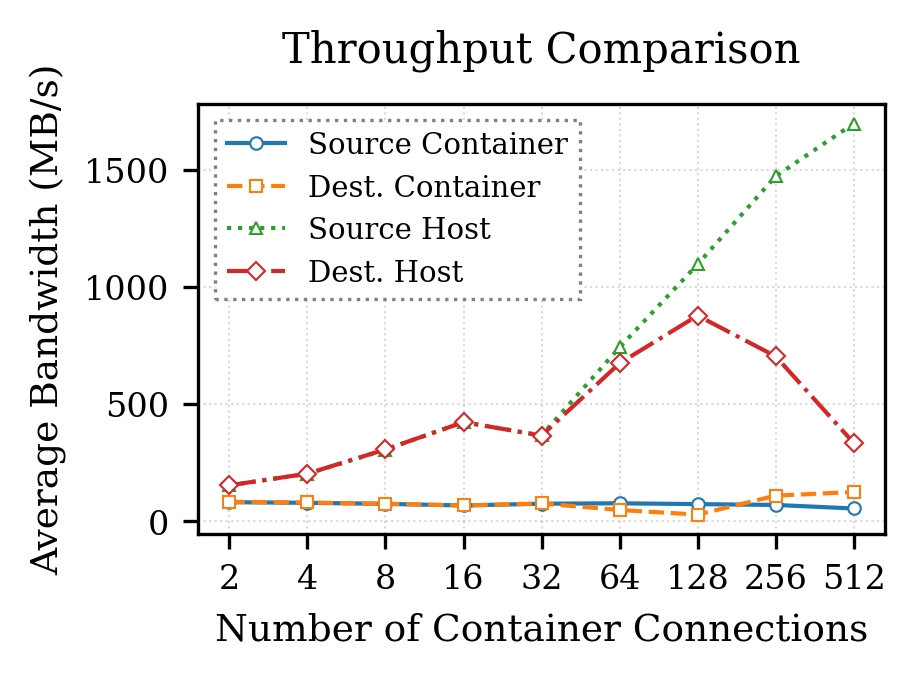

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib

# Use a default serif font that's widely available
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif', 'Liberation Serif', 'Computer Modern Roman']
plt.rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded properly
plt.rcParams['ps.fonttype'] = 42   # Ensure fonts are embedded properly


source_container, dest_container_in, dest_container_out, source_host, dest_host = ret4

# Convert cm to inches (12x8 cm)
cm_to_inch = 1/2.54
width_cm, height_cm = 8, 6
fig = plt.figure(figsize=(width_cm*cm_to_inch, height_cm*cm_to_inch), dpi=300)

# Create x-axis points
x_points = [2, 4, 8, 16, 32, 64, 128, 256, 512]

# Define a professional color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
markers = ['o', 's', '^', 'D', 'v']
linestyles = ['-', '--', ':', '-.', '-']

# Plot each line with improved styling
for i, (data, label) in enumerate([
    (source_container, 'Source Container'),
    (dest_container_in, 'Dest. Container'),
    (source_host, 'Source Host'),
    (dest_host, 'Dest. Host')
]):
    plt.plot(x_points, data, 
             color=colors[i],
             marker=markers[i],
             linestyle=linestyles[i],
             label=label,
             linewidth=1.0,
             markersize=3,
             markerfacecolor='white',
             markeredgewidth=0.5)

# Customize the plot
plt.xlabel('Number of Container Connections', fontsize=9)
plt.ylabel('Average Bandwidth (MB/s)', fontsize=9)
plt.title('Throughput Comparison', fontsize=10, pad=10)

# Set x-axis to log scale (base 2)
plt.xscale('log', base=2)

# Set x-axis ticks and labels
plt.xticks(x_points, [str(x) for x in x_points], fontsize=8)
plt.yticks(fontsize=8)

# Add grid with improved styling
plt.grid(True, linestyle=':', alpha=0.3, color='gray', linewidth=0.5)

# Add legend with padding
legend = plt.legend(loc='upper left', 
                   fontsize=7,
                   frameon=True,
                   edgecolor='gray',
                   borderaxespad=0.1,
                   bbox_to_anchor=(0.02, 0.97),
                   framealpha=1,
                   fancybox=False)

# Get the legend frame and set its line style to dotted
frame = legend.get_frame()
frame.set_linestyle(':')
frame.set_linewidth(0.8)

# Tight layout
plt.tight_layout()

# Uncomment the following line to save as PDF
#plt.savefig('throughput_comparison_orig_new_v1.pdf', format='pdf', bbox_inches='tight', dpi=300)
#plt.savefig('1_one_to_one_traffic_throughput_avg.png', format='png', bbox_inches='tight', dpi=600)
plt.savefig('1_one_to_one_traffic_throughput_avg.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()

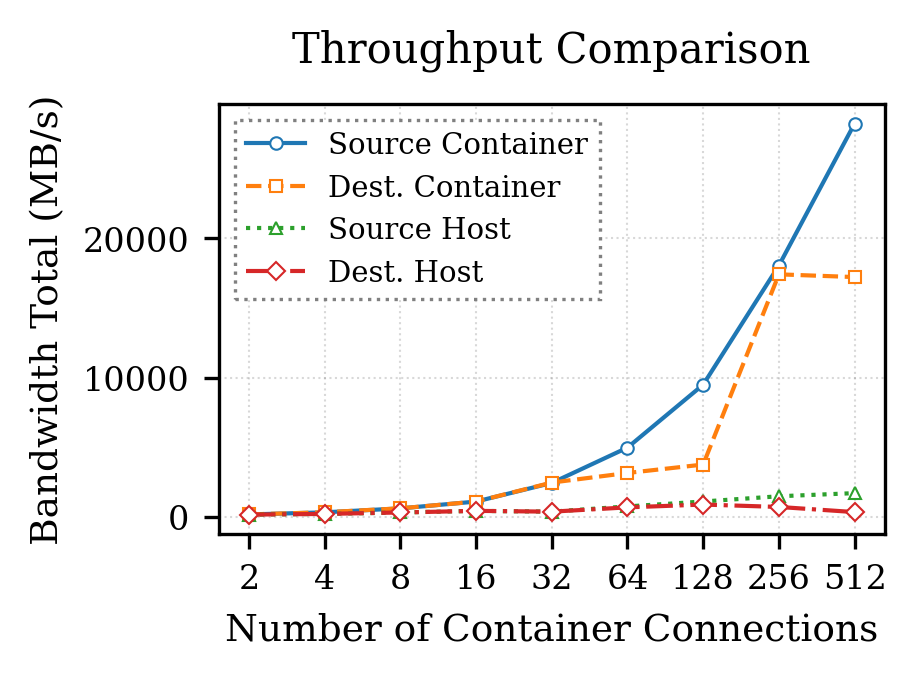

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib

# Use a default serif font that's widely available
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif', 'Liberation Serif', 'Computer Modern Roman']
plt.rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded properly
plt.rcParams['ps.fonttype'] = 42   # Ensure fonts are embedded properly


source_container, dest_container_in, dest_container_out, source_host, dest_host = ret5

# Convert cm to inches (12x8 cm)
cm_to_inch = 1/2.54
width_cm, height_cm = 8, 6
fig = plt.figure(figsize=(width_cm*cm_to_inch, height_cm*cm_to_inch), dpi=300)

# Create x-axis points
x_points = [2, 4, 8, 16, 32, 64, 128, 256, 512]

# Define a professional color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
markers = ['o', 's', '^', 'D', 'v']
linestyles = ['-', '--', ':', '-.', '-']

# Plot each line with improved styling
for i, (data, label) in enumerate([
    (source_container, 'Source Container'),
    (dest_container_in, 'Dest. Container'),
    (source_host, 'Source Host'),
    (dest_host, 'Dest. Host')
]):
    plt.plot(x_points, data, 
             color=colors[i],
             marker=markers[i],
             linestyle=linestyles[i],
             label=label,
             linewidth=1.0,
             markersize=3,
             markerfacecolor='white',
             markeredgewidth=0.5)

# Customize the plot
plt.xlabel('Number of Container Connections', fontsize=9)
plt.ylabel('Bandwidth Total (MB/s)', fontsize=9)
plt.title('Throughput Comparison', fontsize=10, pad=10)

# Set x-axis to log scale (base 2)
plt.xscale('log', base=2)

# Set x-axis ticks and labels
plt.xticks(x_points, [str(x) for x in x_points], fontsize=8)
plt.yticks(fontsize=8)

# Add grid with improved styling
plt.grid(True, linestyle=':', alpha=0.3, color='gray', linewidth=0.5)

# Add legend with padding
legend = plt.legend(loc='upper left', 
                   fontsize=7,
                   frameon=True,
                   edgecolor='gray',
                   borderaxespad=0.1,
                   bbox_to_anchor=(0.02, 0.97),
                   framealpha=1,
                   fancybox=False)

# Get the legend frame and set its line style to dotted
frame = legend.get_frame()
frame.set_linestyle(':')
frame.set_linewidth(0.8)

# Tight layout
plt.tight_layout()

# Uncomment the following line to save as PDF
plt.savefig('1_one_to_one_traffic_throughput_sum.pdf', format='pdf', bbox_inches='tight', dpi=300)
#plt.savefig('1_one_to_one_traffic_throughput_sum.png', format='png', bbox_inches='tight', dpi=600)

plt.show()

In [105]:
def get_latency_average_src(df):
    """
    Calculate average latency for source packets by sections
    Parameters:
    df: DataFrame containing packet data
    Returns:
    dict: Dictionary containing average latencies for e2e and sections
    """
    # Filter for container packets
    container_data = df[df['ContainerName'].str.contains('container:/', na=False)].copy()
    
    if len(container_data) == 0:
        return None
    
    results = {}
    
    # Process each packet hash
    def calculate_section_latencies(group):
        group = group.sort_values('Timestamp')
        
        # Extract timestamps for each hook type
        tc_ts = group[group['Hook'] == 'tc_ingress']['Timestamp'].values
        skb_in_ts = group[group['Hook'] == 'skb_ingress']['Timestamp'].values
        skb_eg_ts = group[group['Hook'] == 'skb_egress']['Timestamp'].values
        
        if len(tc_ts) > 0 and len(skb_in_ts) > 0:
            section1 = abs(tc_ts[0] - skb_in_ts[0])
        else:
            section1 = None
            
        if len(skb_in_ts) > 0 and len(skb_eg_ts) > 0:
            section2 = abs(skb_in_ts[0] - skb_eg_ts[0])
        else:
            section2 = None
            
        if len(tc_ts) > 0 and len(skb_eg_ts) > 0:
            e2e = abs(tc_ts[0] - skb_eg_ts[0])
        else:
            e2e = None
            
        return pd.Series({'section1': section1, 'section2': section2, 'e2e': e2e})
    
    # Calculate latencies for all packets
    latencies = container_data.groupby('PacketHash').apply(calculate_section_latencies)
    
    # Calculate averages, dropping NaN values
    results['section1_avg'] = latencies['section1'].dropna().mean()
    results['section2_avg'] = latencies['section2'].dropna().mean()
    results['e2e_avg'] = latencies['e2e'].dropna().mean()

    print("done - src")
    return results

def get_latency_average_dst(df):
    """
    Calculate average latency for destination packets by sections
    Parameters:
    df: DataFrame containing packet data
    Returns:
    dict: Dictionary containing average latencies for e2e and sections
    """
    # Filter for container packets
    container_data = df[df['ContainerName'].str.contains('container:/', na=False)].copy()
    
    if len(container_data) == 0:
        return None
    
    results = {}
    
    # Process each packet hash
    def calculate_section_latencies(group):
        group = group.sort_values('Timestamp')
        
        # Extract timestamps for each hook type
        tc_ts = group[group['Hook'] == 'tc_ingress']['Timestamp'].values
        skb_in_ts = group[group['Hook'] == 'skb_ingress']['Timestamp'].values
        skb_eg_ts = group[group['Hook'] == 'skb_egress']['Timestamp'].values
        
        if len(tc_ts) > 0 and len(skb_in_ts) > 0:
            section1 = abs(tc_ts[0] - skb_in_ts[0])
        else:
            section1 = None
            
        if len(skb_in_ts) > 0 and len(skb_eg_ts) > 0:
            section2 = abs(skb_in_ts[0] - skb_eg_ts[0])
        else:
            section2 = None
            
        if len(tc_ts) > 0 and len(skb_eg_ts) > 0:
            e2e = abs(tc_ts[0] - skb_eg_ts[0])
        else:
            e2e = None
            
        return pd.Series({'section1': section1, 'section2': section2, 'e2e': e2e})
    
    # Calculate latencies for all packets
    latencies = container_data.groupby('PacketHash').apply(calculate_section_latencies)
    
    # Calculate averages, dropping NaN values
    results['section1_avg'] = latencies['section1'].dropna().mean()
    results['section2_avg'] = latencies['section2'].dropna().mean()
    results['e2e_avg'] = latencies['e2e'].dropna().mean()

    print("done - dst")
    return results

In [106]:
src_latency_list = []
src_latency_list.append(get_latency_average_src(df_src_2))
src_latency_list.append(get_latency_average_src(df_src_4))
src_latency_list.append(get_latency_average_src(df_src_8))
src_latency_list.append(get_latency_average_src(df_src_16))
src_latency_list.append(get_latency_average_src(df_src_32))
src_latency_list.append(get_latency_average_src(df_src_64))
src_latency_list.append(get_latency_average_src(df_src_128))
src_latency_list.append(get_latency_average_src(df_src_256))
src_latency_list.append(get_latency_average_src(df_src_512))

# Using dictionary keys instead of indices
src_e2e_lat = [x['e2e_avg'] for x in src_latency_list]
src_sec_1_lat = [x['section1_avg'] for x in src_latency_list]
src_sec_2_lat = [x['section2_avg'] for x in src_latency_list]

dst_latency_list = []
dst_latency_list.append(get_latency_average_dst(df_dst_2))
dst_latency_list.append(get_latency_average_dst(df_dst_4))
dst_latency_list.append(get_latency_average_dst(df_dst_8))
dst_latency_list.append(get_latency_average_dst(df_dst_16))
dst_latency_list.append(get_latency_average_dst(df_dst_32))
dst_latency_list.append(get_latency_average_dst(df_dst_64))
dst_latency_list.append(get_latency_average_dst(df_dst_128))
dst_latency_list.append(get_latency_average_dst(df_dst_256))
dst_latency_list.append(get_latency_average_dst(df_dst_512))

# Using dictionary keys instead of indices
dst_e2e_lat = [x['e2e_avg'] for x in dst_latency_list]
dst_sec_1_lat = [x['section1_avg'] for x in dst_latency_list]
dst_sec_2_lat = [x['section2_avg'] for x in dst_latency_list]

done - src
done - src
done - src
done - src
done - src
done - src
done - src
done - src
done - src
done - dst
done - dst
done - dst
done - dst
done - dst
done - dst
done - dst
done - dst
done - dst


In [113]:
def get_latency_average_src2(df):
    """
    Calculate average latency for source packets by sections
    Parameters:
    df: DataFrame containing packet data
    Returns:
    dict: Dictionary containing average latencies for e2e and sections
    """
    # Filter for container packets
    container_data = df[df['ContainerName'].str.contains('container:/', na=False)].copy()
    
    if len(container_data) == 0:
        return None
    
    results = {}
    
    # Process each packet hash
    def calculate_section_latencies(group):
        # Sort by timestamp to ensure correct order
        group = group.sort_values('Timestamp')
        
        # Extract timestamps for each hook type
        tc_ingress = group[group['Hook'] == 'tc_ingress']['Timestamp'].iloc[0] if any(group['Hook'] == 'tc_ingress') else None
        skb_ingress = group[group['Hook'] == 'skb_ingress']['Timestamp'].iloc[0] if any(group['Hook'] == 'skb_ingress') else None
        skb_egress = group[group['Hook'] == 'skb_egress']['Timestamp'].iloc[0] if any(group['Hook'] == 'skb_egress') else None
        
        # Calculate latencies only if both timestamps exist for each section
        section1 = abs(tc_ingress - skb_ingress) if tc_ingress is not None and skb_ingress is not None else None
        section2 = abs(skb_ingress - skb_egress) if skb_ingress is not None and skb_egress is not None else None
        e2e = abs(tc_ingress - skb_egress) if tc_ingress is not None and skb_egress is not None else None
        
        return pd.Series({'section1': section1, 'section2': section2, 'e2e': e2e})
    
    # Calculate latencies for all packets
    latencies = container_data.groupby('PacketHash').apply(calculate_section_latencies)
    
    # Calculate averages, dropping NaN values
    results['section1_avg'] = latencies['section1'].dropna().mean()
    results['section2_avg'] = latencies['section2'].dropna().mean()
    results['e2e_avg'] = latencies['e2e'].dropna().mean()
    
    return results

In [114]:
src_latency_list[4] = get_latency_average_src2(df_dst_32)


In [115]:
src_latency_list

[{'section1_avg': np.float64(8924.642857142857),
  'section2_avg': np.float64(3230.4285714285716),
  'e2e_avg': np.float64(12155.07142857143)},
 {'section1_avg': np.float64(6309.4),
  'section2_avg': np.float64(2550.714285714286),
  'e2e_avg': np.float64(8860.114285714286)},
 {'section1_avg': np.float64(7087.035714285715),
  'section2_avg': np.float64(2143.089285714286),
  'e2e_avg': np.float64(9230.125)},
 {'section1_avg': np.float64(4469.535714285715),
  'section2_avg': np.float64(1798.0714285714287),
  'e2e_avg': np.float64(6267.607142857143)},
 {'section1_avg': np.float64(2349.7015514898726),
  'section2_avg': np.float64(1502.2118798791237),
  'e2e_avg': np.float64(3852.4213987605917)},
 {'section1_avg': np.float64(3723.9417040358744),
  'section2_avg': np.float64(1718.8674157303371),
  'e2e_avg': np.float64(5445.885393258427)},
 {'section1_avg': np.float64(3607.083518930958),
  'section2_avg': np.float64(1711.9601328903655),
  'e2e_avg': np.float64(5318.70267260579)},
 {'section1_

In [116]:
src_latency_list

[{'section1_avg': np.float64(8924.642857142857),
  'section2_avg': np.float64(3230.4285714285716),
  'e2e_avg': np.float64(12155.07142857143)},
 {'section1_avg': np.float64(6309.4),
  'section2_avg': np.float64(2550.714285714286),
  'e2e_avg': np.float64(8860.114285714286)},
 {'section1_avg': np.float64(7087.035714285715),
  'section2_avg': np.float64(2143.089285714286),
  'e2e_avg': np.float64(9230.125)},
 {'section1_avg': np.float64(4469.535714285715),
  'section2_avg': np.float64(1798.0714285714287),
  'e2e_avg': np.float64(6267.607142857143)},
 {'section1_avg': np.float64(2349.7015514898726),
  'section2_avg': np.float64(1502.2118798791237),
  'e2e_avg': np.float64(3852.4213987605917)},
 {'section1_avg': np.float64(3723.9417040358744),
  'section2_avg': np.float64(1718.8674157303371),
  'e2e_avg': np.float64(5445.885393258427)},
 {'section1_avg': np.float64(3607.083518930958),
  'section2_avg': np.float64(1711.9601328903655),
  'e2e_avg': np.float64(5318.70267260579)},
 {'section1_

In [8]:
dst_latency_list

NameError: name 'dst_latency_list' is not defined

In [2]:
src_latency_list = [{'section1_avg': np.float64(8924.642857142857),
  'section2_avg': np.float64(3230.4285714285716),
  'e2e_avg': np.float64(12155.07142857143)},
 {'section1_avg': np.float64(6309.4),
  'section2_avg': np.float64(2550.714285714286),
  'e2e_avg': np.float64(8860.114285714286)},
 {'section1_avg': np.float64(7087.035714285715),
  'section2_avg': np.float64(2143.089285714286),
  'e2e_avg': np.float64(9230.125)},
 {'section1_avg': np.float64(4469.535714285715),
  'section2_avg': np.float64(1798.0714285714287),
  'e2e_avg': np.float64(6267.607142857143)},
 {'section1_avg': np.float64(2349.7015514898726),
  'section2_avg': np.float64(1502.2118798791237),
  'e2e_avg': np.float64(3852.4213987605917)},
 {'section1_avg': np.float64(3723.9417040358744),
  'section2_avg': np.float64(1718.8674157303371),
  'e2e_avg': np.float64(5445.885393258427)},
 {'section1_avg': np.float64(3607.083518930958),
  'section2_avg': np.float64(1711.9601328903655),
  'e2e_avg': np.float64(5318.70267260579)},
 {'section1_avg': np.float64(3579.7097493036213),
  'section2_avg': np.float64(1679.5703951029493),
  'e2e_avg': np.float64(5256.419408812047)},
 {'section1_avg': np.float64(1162373.7440978077),
  'section2_avg': np.float64(1639.7771388499298),
  'e2e_avg': np.float64(1164827.8014343975)}]

In [3]:
# Using dictionary keys instead of indices
src_e2e_lat = [x['e2e_avg'] for x in src_latency_list]
src_sec_1_lat = [x['section1_avg'] for x in src_latency_list]
src_sec_2_lat = [x['section2_avg'] for x in src_latency_list]

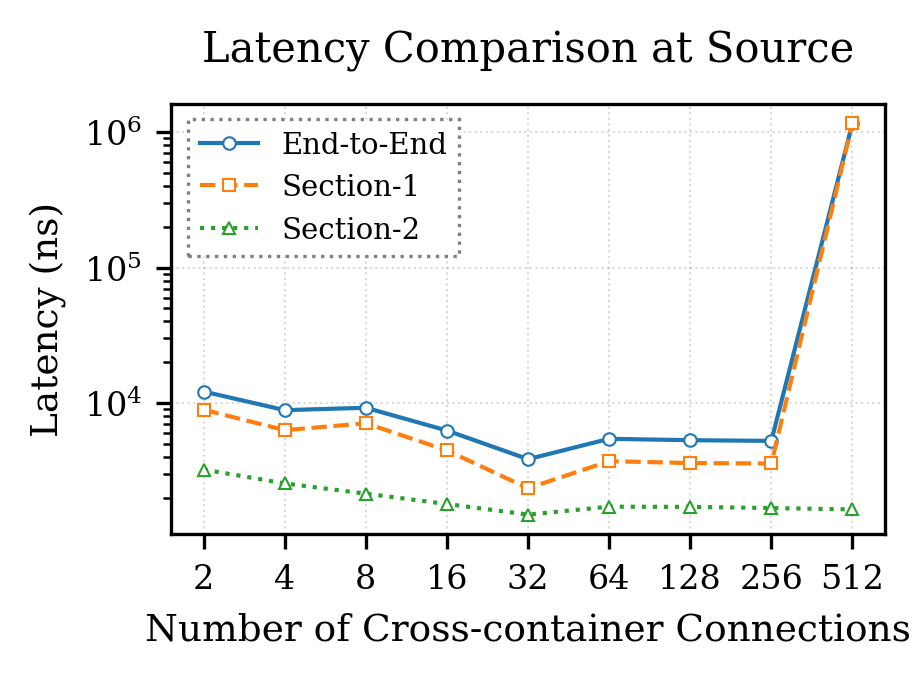

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib

# Use a default serif font that's widely available
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif', 'Liberation Serif', 'Computer Modern Roman']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Convert cm to inches
cm_to_inch = 1/2.54
width_cm, height_cm = 8, 6
fig = plt.figure(figsize=(width_cm*cm_to_inch, height_cm*cm_to_inch), dpi=300)

# Create x-axis points
x_points = np.arange(len(src_e2e_lat))

# Define a professional color palette and styles
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
markers = ['o', 's', '^']
linestyles = ['-', '--', ':']

# Plot each SEPARATE line
plt.plot(x_points, src_e2e_lat, 
         color=colors[0],
         marker=markers[0],
         linestyle=linestyles[0],
         label='End-to-End',
         linewidth=1.0,
         markersize=3,
         markerfacecolor='white',
         markeredgewidth=0.5)

plt.plot(x_points, src_sec_1_lat, 
         color=colors[1],
         marker=markers[1],
         linestyle=linestyles[1],
         label='Section-1',
         linewidth=1.0,
         markersize=3,
         markerfacecolor='white',
         markeredgewidth=0.5)

plt.plot(x_points, src_sec_2_lat, 
         color=colors[2],
         marker=markers[2],
         linestyle=linestyles[2],
         label='Section-2',
         linewidth=1.0,
         markersize=3,
         markerfacecolor='white',
         markeredgewidth=0.5)

plt.xlabel('Number of Cross-container Connections', fontsize=9)
plt.ylabel('Latency (ns)', fontsize=9)
plt.yscale('log')

plt.title('Latency Comparison at Source', fontsize=10, pad=10)

plt.xticks(x_points, [2, 4, 8, 16, 32, 64, 128, 256, 512], fontsize=8)
plt.yticks(fontsize=8)

plt.grid(True, linestyle=':', alpha=0.3, color='gray', linewidth=0.5)

# Add legend with padding
legend = plt.legend(loc='upper left', 
                   fontsize=7,
                   frameon=True,
                   edgecolor='gray',
                   borderaxespad=0.1,
                   bbox_to_anchor=(0.02, 0.97),
                   framealpha=1,
                   fancybox=False)

frame = legend.get_frame()
frame.set_linestyle(':')
frame.set_linewidth(0.8)

plt.tight_layout()
plt.savefig('1_one_to_one_traffic_latency_src.pdf', format='pdf', bbox_inches='tight', dpi=300)
#plt.savefig('1_one_to_one_traffic_latency_src.png', format='png', bbox_inches='tight', dpi=600)


plt.show()

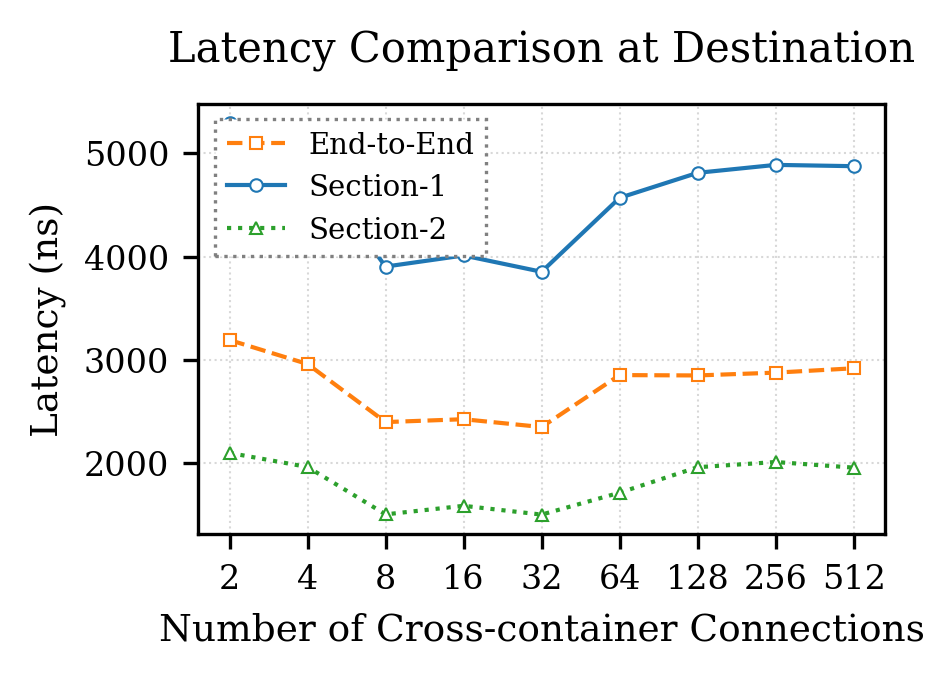

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib

# Use a default serif font that's widely available
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif', 'Liberation Serif', 'Computer Modern Roman']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Convert cm to inches
cm_to_inch = 1/2.54
width_cm, height_cm = 8, 6
fig = plt.figure(figsize=(width_cm*cm_to_inch, height_cm*cm_to_inch), dpi=300)

# Create x-axis points
x_points = np.arange(len(dst_e2e_lat))

# Define a professional color palette and styles
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
markers = ['o', 's', '^']
linestyles = ['-', '--', ':']


# Plot each SEPARATE line
plt.plot(x_points, dst_e2e_lat, 
         color=colors[0],
         marker=markers[0],
         linestyle=linestyles[0],
         label='End-to-End',
         linewidth=1.0,
         markersize=3,
         markerfacecolor='white',
         markeredgewidth=0.5)

plt.plot(x_points, dst_sec_1_lat, 
         color=colors[1],
         marker=markers[1],
         linestyle=linestyles[1],
         label='Section-1',
         linewidth=1.0,
         markersize=3,
         markerfacecolor='white',
         markeredgewidth=0.5)

plt.plot(x_points, dst_sec_2_lat, 
         color=colors[2],
         marker=markers[2],
         linestyle=linestyles[2],
         label='Section-2',
         linewidth=1.0,
         markersize=3,
         markerfacecolor='white',
         markeredgewidth=0.5)

plt.xlabel('Number of Cross-container Connections', fontsize=9)
plt.ylabel('Latency (ns)', fontsize=9)
plt.title('Latency Comparison at Destination', fontsize=10, pad=10)

plt.xticks(x_points, [2, 4, 8, 16, 32, 64, 128, 256, 512], fontsize=8)
plt.yticks(fontsize=8)

plt.grid(True, linestyle=':', alpha=0.3, color='gray', linewidth=0.5)

# Add legend with padding
legend = plt.legend(loc='upper left', 
                   fontsize=7,
                   frameon=True,
                   edgecolor='gray',
                   borderaxespad=0.1,
                   bbox_to_anchor=(0.02, 0.97),
                   framealpha=1,
                   fancybox=False)

frame = legend.get_frame()
frame.set_linestyle(':')
frame.set_linewidth(0.8)

#plt.savefig('1_one_to_one_traffic_latency_dst.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.savefig('1_one_to_one_traffic_latency_dst.png', format='png', bbox_inches='tight', dpi=600)

plt.tight_layout()
plt.show()

In [22]:
df_src_2 = pd.read_csv('data/inter/1_two_to_two_src.csv')
df_dst_2 = pd.read_csv('data/inter/1_two_to_two_dst.csv')

df_src_4 = pd.read_csv('data/inter/1_four_to_four_src.csv')
df_dst_4 = pd.read_csv('data/inter/1_four_to_four_dst.csv')

df_src_8 = pd.read_csv('data/inter/1_8_to_8_src.csv')
df_dst_8 = pd.read_csv('data/inter/1_8_to_8_dst.csv')

df_src_16 = pd.read_csv('data/inter/1_16_to_16_src.csv')
df_dst_16 = pd.read_csv('data/inter/1_16_to_16_dst.csv')

df_src_32 = pd.read_csv('data/inter/1_32_to_32_src.csv')
df_dst_32 = pd.read_csv('data/inter/1_32_to_32_dst.csv')

df_src_64 = pd.read_csv('data/inter/1_64_to_64_src.csv')
df_dst_64 = pd.read_csv('data/inter/1_64_to_64_dst.csv')

df_src_128 = pd.read_csv('data/inter/1_128_to_128_src.csv')
df_dst_128 = pd.read_csv('data/inter/1_128_to_128_dst.csv')

df_src_256 = pd.read_csv('data/inter/1_256_to_256_src.csv') #bad
df_dst_256 = pd.read_csv('data/inter/1_256_to_256_dst.csv') #bad

df_src_512 = pd.read_csv('data/inter/1_512_to_512_src.csv') #bad
df_dst_512 = pd.read_csv('data/inter/1_512_to_512_dst.csv') #bad

ret2 = generate_saturation_2([df_src_2, df_src_4, df_src_8, df_src_16, df_src_32, df_src_64, df_src_128, df_src_256, df_src_512], 
                             [df_dst_2, df_dst_4, df_dst_8, df_dst_16, df_dst_32, df_dst_64, df_dst_128, df_dst_256, df_dst_512])

ret3 = ret2[:]

==== src:2 -> dst:2 ====
Average SRC in container throughput = avg 75.15 MB/s, sum 150.31 MB/s
Average SRC host throughput = 136.86 MB/s
Average DST in container throughput = avg 74.91 MB/s, sum 149.81 MB/s
Average DST out container throughput = avg 75.44 MB/s, sum 150.87 MB/s
Average DST host throughput = 136.89 MB/s
==== src:4 -> dst:4 ====
Average SRC in container throughput = avg 73.16 MB/s, sum 292.66 MB/s
Average SRC host throughput = 260.48 MB/s
Average DST in container throughput = avg 72.70 MB/s, sum 290.78 MB/s
Average DST out container throughput = avg 73.23 MB/s, sum 292.92 MB/s
Average DST host throughput = 260.41 MB/s
==== src:8 -> dst:8 ====
Average SRC in container throughput = avg 81.21 MB/s, sum 649.64 MB/s
Average SRC host throughput = 527.91 MB/s
Average DST in container throughput = avg 80.65 MB/s, sum 645.19 MB/s
Average DST out container throughput = avg 81.30 MB/s, sum 650.40 MB/s
Average DST host throughput = 527.65 MB/s
==== src:16 -> dst:16 ====
Average SRC i

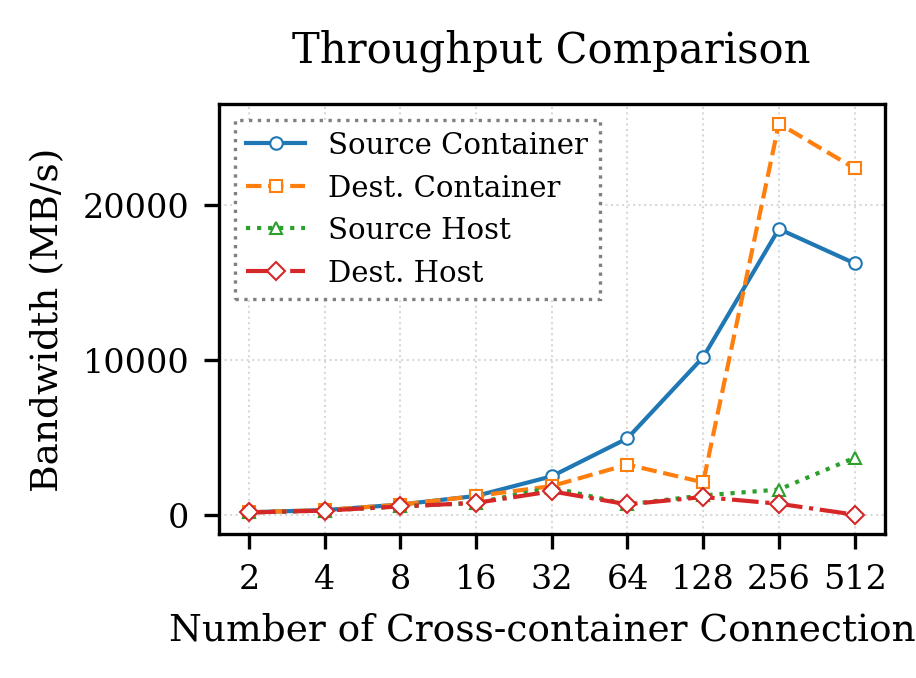

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib

# Use a default serif font that's widely available
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif', 'Liberation Serif', 'Computer Modern Roman']
plt.rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded properly
plt.rcParams['ps.fonttype'] = 42   # Ensure fonts are embedded properly


source_container, dest_container_in, dest_container_out, source_host, dest_host = ret2

# Convert cm to inches (12x8 cm)
cm_to_inch = 1/2.54
width_cm, height_cm = 8, 6
fig = plt.figure(figsize=(width_cm*cm_to_inch, height_cm*cm_to_inch), dpi=300)

# Create x-axis points
x_points = [2, 4, 8, 16, 32, 64, 128, 256, 512]

# Define a professional color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
markers = ['o', 's', '^', 'D', 'v']
linestyles = ['-', '--', ':', '-.', '-']

# Plot each line with improved styling
for i, (data, label) in enumerate([
    (source_container, 'Source Container'),
    (dest_container_in, 'Dest. Container'),
    (source_host, 'Source Host'),
    (dest_host, 'Dest. Host')
]):
    plt.plot(x_points, data, 
             color=colors[i],
             marker=markers[i],
             linestyle=linestyles[i],
             label=label,
             linewidth=1.0,
             markersize=3,
             markerfacecolor='white',
             markeredgewidth=0.5)

# Customize the plot
plt.xlabel('Number of Cross-container Connections', fontsize=9)
plt.ylabel('Bandwidth (MB/s)', fontsize=9)
plt.title('Throughput Comparison', fontsize=10, pad=10)

# Set x-axis to log scale (base 2)
plt.xscale('log', base=2)

# Set x-axis ticks and labels
plt.xticks(x_points, [str(x) for x in x_points], fontsize=8)
plt.yticks(fontsize=8)

# Add grid with improved styling
plt.grid(True, linestyle=':', alpha=0.3, color='gray', linewidth=0.5)

# Add legend with padding
legend = plt.legend(loc='upper left', 
                   fontsize=7,
                   frameon=True,
                   edgecolor='gray',
                   borderaxespad=0.1,
                   bbox_to_anchor=(0.02, 0.97),
                   framealpha=1,
                   fancybox=False)

# Get the legend frame and set its line style to dotted
frame = legend.get_frame()
frame.set_linestyle(':')
frame.set_linewidth(0.8)

# Tight layout
plt.tight_layout()

# Uncomment the following line to save as PDF
plt.savefig('throughput_comparison_orig.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()

In [26]:
from copy import deepcopy
ret3 = deepcopy(ret2)

In [27]:
ret3

([150.30857181155568,
  292.6561348681611,
  649.6439740743942,
  1205.8170962030413,
  2475.126045675375,
  4929.526600221218,
  10167.891538802245,
  18452.278884979398,
  16230.95728378414],
 [149.8100126748431,
  290.7802407872354,
  645.1939493126141,
  1197.2418687706952,
  1843.7318663301205,
  3230.6959555985804,
  2085.8646684802575,
  25259.462672874128,
  22372.944932479902],
 [150.8711223025657,
  292.9217422396243,
  650.4030429616264,
  1205.2568467405845,
  1964.9927011716622,
  3573.541322750939,
  4110.356304805573,
  1580.1948341631978,
  943.9950577006143],
 [np.float64(136.86230721416257),
  np.float64(260.47878741370164),
  np.float64(527.9132565956038),
  np.float64(759.0833394431676),
  np.float64(1747.9933366181324),
  np.float64(660.367219332719),
  np.float64(1239.7357456329178),
  np.float64(1618.3787723681137),
  np.float64(3673.968178816937)],
 [np.float64(136.88767391265625),
  np.float64(260.40962196724973),
  np.float64(527.6467424491931),
  np.float64(7

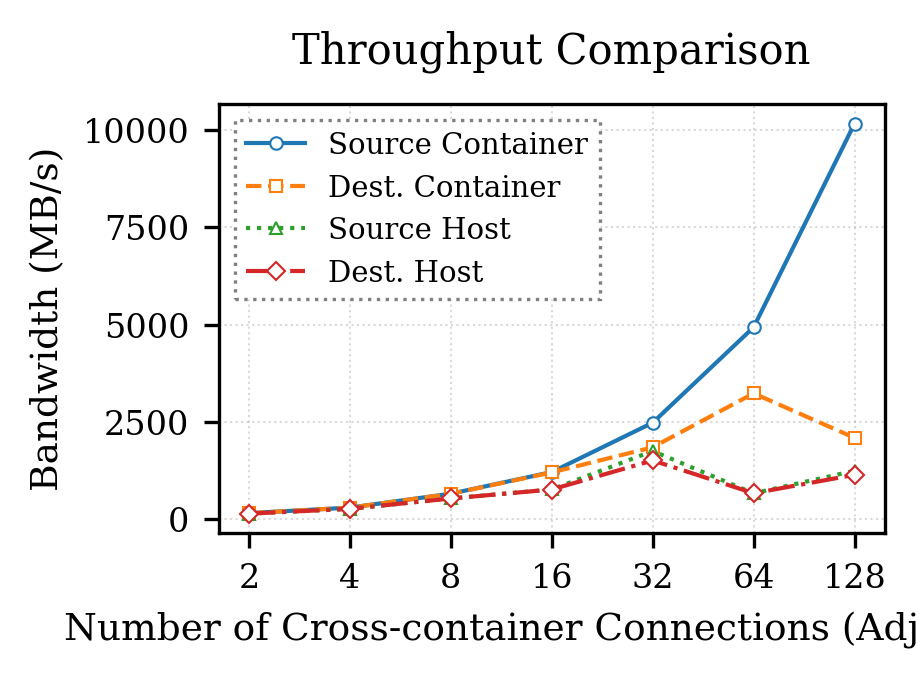

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib

# Use a default serif font that's widely available
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif', 'Liberation Serif', 'Computer Modern Roman']
plt.rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded properly
plt.rcParams['ps.fonttype'] = 42   # Ensure fonts are embedded properly

source_container, dest_container_in, dest_container_out, source_host, dest_host = ret3
dest_container_in[7] = dest_container_in[7]//4
dest_container_in[8] = dest_container_in[8]//4

# Convert cm to inches (12x8 cm)
cm_to_inch = 1/2.54
width_cm, height_cm = 8, 6
fig = plt.figure(figsize=(width_cm*cm_to_inch, height_cm*cm_to_inch), dpi=300)

dest_container_in = dest_container_in[:7]
source_container = source_container[:7]
dest_container_out = dest_container_out[:7]
source_host = source_host[:7]
dest_host = dest_host[:7]

# Create x-axis points
x_points = [2, 4, 8, 16, 32, 64, 128]

# Define a professional color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
markers = ['o', 's', '^', 'D', 'v']
linestyles = ['-', '--', ':', '-.', '-']

# Plot each line with improved styling
for i, (data, label) in enumerate([
    (source_container, 'Source Container'),
    (dest_container_in, 'Dest. Container'),
    (source_host, 'Source Host'),
    (dest_host, 'Dest. Host')
]):
    plt.plot(x_points, data, 
             color=colors[i],
             marker=markers[i],
             linestyle=linestyles[i],
             label=label,
             linewidth=1.0,
             markersize=3,
             markerfacecolor='white',
             markeredgewidth=0.5)

# Customize the plot
plt.xlabel('Number of Cross-container Connections (Adjusted)', fontsize=9)
plt.ylabel('Bandwidth (MB/s)', fontsize=9)
plt.title('Throughput Comparison', fontsize=10, pad=10)

# Set x-axis to log scale (base 2)
plt.xscale('log', base=2)

# Set x-axis ticks and labels
plt.xticks(x_points, [str(x) for x in x_points], fontsize=8)
plt.yticks(fontsize=8)

# Add grid with improved styling
plt.grid(True, linestyle=':', alpha=0.3, color='gray', linewidth=0.5)

# Add legend with padding
legend = plt.legend(loc='upper left', 
                   fontsize=7,
                   frameon=True,
                   edgecolor='gray',
                   borderaxespad=0.1,
                   bbox_to_anchor=(0.02, 0.97),
                   framealpha=1,
                   fancybox=False)

# Get the legend frame and set its line style to dotted
frame = legend.get_frame()
frame.set_linestyle(':')
frame.set_linewidth(0.8)

# Tight layout
plt.tight_layout()

# Uncomment the following line to save as PDF
plt.savefig('throughput_comparison_adjusted.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()

ValueError: x and y must have same first dimension, but have shapes (7,) and (9,)

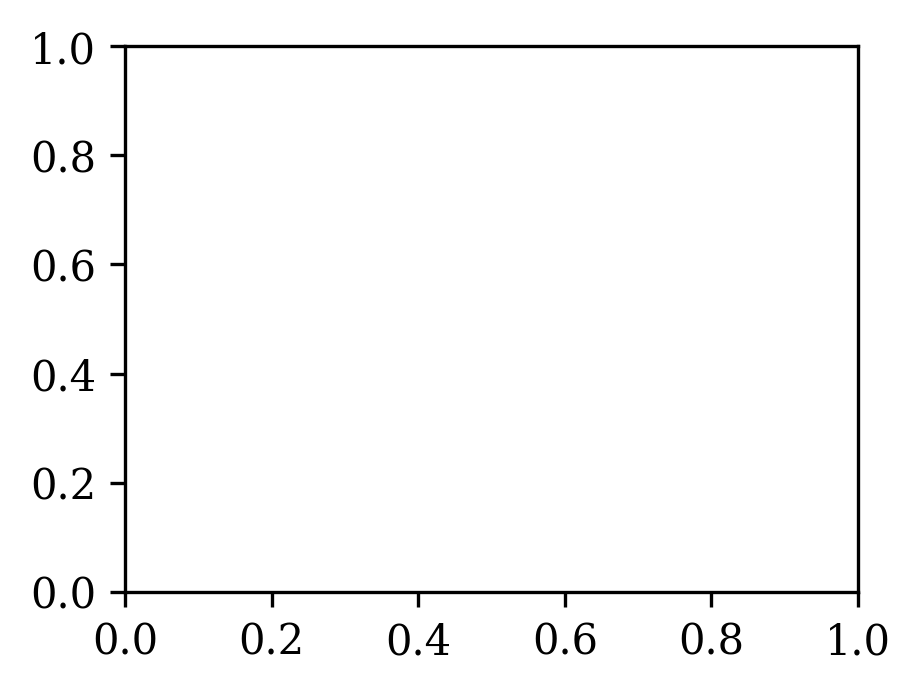

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib

# Use a default serif font that's widely available
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif', 'Liberation Serif', 'Computer Modern Roman']
plt.rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded properly
plt.rcParams['ps.fonttype'] = 42   # Ensure fonts are embedded properly

source_container, dest_container_in, dest_container_out, source_host, dest_host = ret2

# Convert cm to inches (12x8 cm)
cm_to_inch = 1/2.54
width_cm, height_cm = 8, 6
fig = plt.figure(figsize=(width_cm*cm_to_inch, height_cm*cm_to_inch), dpi=300)

# Create x-axis points
x_points = [2, 4, 8, 16, 32, 64, 128]

# Define a professional color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
markers = ['o', 's', '^', 'D', 'v']
linestyles = ['-', '--', ':', '-.', '-']

# Plot each line with improved styling
for i, (data, label) in enumerate([
    (source_container, 'Source Container'),
    (dest_container_in, 'Dest. Container'),
    (source_host, 'Source Host'),
    (dest_host, 'Dest. Host')
]):
    plt.plot(x_points, data, 
             color=colors[i],
             marker=markers[i],
             linestyle=linestyles[i],
             label=label,
             linewidth=1.0,
             markersize=3,
             markerfacecolor='white',
             markeredgewidth=0.5)

# Customize the plot
plt.xlabel('Number of Cross-container Connections', fontsize=9)
plt.ylabel('Bandwidth (MB/s)', fontsize=9)
plt.title('Throughput Comparison', fontsize=10, pad=10)

# Set x-axis to log scale (base 2)
plt.xscale('log', base=2)

# Set x-axis ticks and labels
plt.xticks(x_points, [str(x) for x in x_points], fontsize=8)
plt.yticks(fontsize=8)

# Add grid with improved styling
plt.grid(True, linestyle=':', alpha=0.3, color='gray', linewidth=0.5)

# Add legend with padding
legend = plt.legend(loc='upper left', 
                   fontsize=7,
                   frameon=True,
                   edgecolor='gray',
                   borderaxespad=0.1,
                   bbox_to_anchor=(0.02, 0.97),
                   framealpha=1,
                   fancybox=False)

# Get the legend frame and set its line style to dotted
frame = legend.get_frame()
frame.set_linestyle(':')
frame.set_linewidth(0.8)

# Tight layout
plt.tight_layout()

# Uncomment the following line to save as PDF
#plt.savefig('throughput_comparison.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()

In [1007]:
import pandas as pd
import numpy as np

def calculate_packet_latencies(df):
    """
    Calculate average latencies for packet traces through different hooks.
    Returns [avg_end_to_end, avg_section1, avg_section2] latencies in nanoseconds.
    """
    # Filter container packets
    df_filtered = df[df['ContainerName'].str.startswith('container:/', na=False)]
    
    if df_filtered.empty:
        return [0, 0, 0]

    # Group by PacketHash and calculate latencies for each packet
    end_to_end_latencies = []
    section1_latencies = []
    section2_latencies = []

    for packet_hash in df_filtered['PacketHash'].unique():
        packet_data = df_filtered[df_filtered['PacketHash'] == packet_hash]
        
        if not all(hook in packet_data['Hook'].values for hook in ['tc_ingress', 'skb_ingress', 'skb_egress']):
            continue

        tc_ingress = float(packet_data[packet_data['Hook'] == 'tc_ingress']['Timestamp'].iloc[0])
        skb_ingress = float(packet_data[packet_data['Hook'] == 'skb_ingress']['Timestamp'].iloc[0])
        skb_egress = float(packet_data[packet_data['Hook'] == 'skb_egress']['Timestamp'].iloc[0])

        end_to_end_latencies.append(skb_egress - tc_ingress)
        section1_latencies.append(skb_ingress - tc_ingress)
        section2_latencies.append(skb_egress - skb_ingress)

    # Calculate averages
    if not end_to_end_latencies:  # If no valid packets were processed
        return [0, 0, 0]

    avg_end_to_end = np.mean(end_to_end_latencies)
    avg_section1 = np.mean(section1_latencies)
    avg_section2 = np.mean(section2_latencies)

    return [avg_end_to_end, avg_section1, avg_section2]

In [918]:
def calculate_packet_latencies_3(df):
    """
    Calculate average latencies using vectorized operations with error handling.
    Returns [avg_end_to_end, avg_section1, avg_section2] latencies in nanoseconds.
    Also prints debugging information for negative latencies.
    """
    # Filter container packets
    df_filtered = df[df['ContainerName'].str.startswith('container:/', na=False)]
    
    if df_filtered.empty:
        return [0, 0, 0]

    # Create pivot table with all timestamps at once
    pivot = df_filtered.pivot_table(
        index='PacketHash',
        columns='Hook',
        values='Timestamp',
        aggfunc='first'
    )
    
    # Calculate latencies for each packet
    end_to_end = pivot['skb_egress'] - pivot['tc_ingress']
    section1 = pivot['skb_ingress'] - pivot['tc_ingress']
    section2 = pivot['skb_egress'] - pivot['skb_ingress']
    
    # Print debug information for negative latencies
    if (end_to_end < 0).any():
        print("\nNegative end-to-end latencies detected:")
        negative_packets = pivot[end_to_end < 0]
        print(negative_packets)
        print("\nPacket hashes with negative latencies:", 
              pivot.index[end_to_end < 0].tolist())
    
    # Option 1: Filter out negative values
    end_to_end_filtered = end_to_end[end_to_end >= 0]
    section1_filtered = section1[section1 >= 0]
    section2_filtered = section2[section2 >= 0]
    
    # Calculate averages using only positive values
    avg_end_to_end = end_to_end_filtered.mean() if not end_to_end_filtered.empty else 0
    avg_section1 = section1_filtered.mean() if not section1_filtered.empty else 0
    avg_section2 = section2_filtered.mean() if not section2_filtered.empty else 0
    
    return [avg_end_to_end, avg_section1, avg_section2]

In [1046]:
latency_list = []
latency_list.append(calculate_packet_latencies_3(df_dst_2))
latency_list.append(calculate_packet_latencies_3(df_dst_4))
latency_list.append(calculate_packet_latencies_3(df_dst_8))
latency_list.append(calculate_packet_latencies_3(df_dst_16))
latency_list.append(calculate_packet_latencies_3(df_dst_32))
latency_list.append(calculate_packet_latencies_3(df_dst_64))
latency_list.append(calculate_packet_latencies_3(df_dst_128))


Negative end-to-end latencies detected:
Hook          skb_egress   skb_ingress  tc_egress    tc_ingress
PacketHash                                                     
697108983   4.231545e+13  4.231545e+13        NaN  4.231545e+13

Packet hashes with negative latencies: [697108983]

Negative end-to-end latencies detected:
Hook          skb_egress   skb_ingress  tc_egress    tc_ingress
PacketHash                                                     
798736208   4.123525e+13  4.123525e+13        NaN  4.123538e+13
820799150   4.123528e+13  4.123534e+13        NaN  4.123534e+13
1164954569  4.123527e+13  4.123528e+13        NaN  4.123528e+13
2359089152  4.123526e+13  4.123526e+13        NaN  4.123540e+13

Packet hashes with negative latencies: [798736208, 820799150, 1164954569, 2359089152]

Negative end-to-end latencies detected:
Hook          skb_egress   skb_ingress  tc_egress    tc_ingress
PacketHash                                                     
998615115   4.273542e+13  4.273547

In [1047]:
e2e_lat = [x[0] for x in latency_list]
sec_1_lat = [x[1] for x in latency_list]
sec_2_lat = [x[2] for x in latency_list]

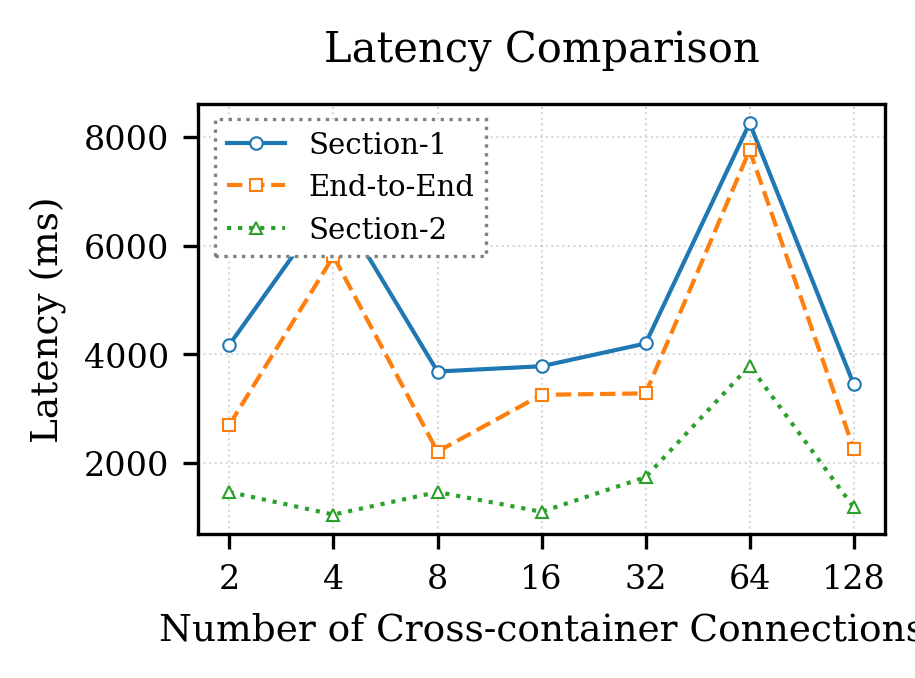

In [1049]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib

# Use a default serif font that's widely available
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif', 'Liberation Serif', 'Computer Modern Roman']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# Convert cm to inches
cm_to_inch = 1/2.54
width_cm, height_cm = 8, 6
fig = plt.figure(figsize=(width_cm*cm_to_inch, height_cm*cm_to_inch), dpi=300)

# Create x-axis points
x_points = np.arange(len(e2e_lat))

# Define a professional color palette and styles
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
markers = ['o', 's', '^']
linestyles = ['-', '--', ':']

# Plot each SEPARATE line
plt.plot(x_points, e2e_lat, 
         color=colors[0],
         marker=markers[0],
         linestyle=linestyles[0],
         label='Section-1',
         linewidth=1.0,
         markersize=3,
         markerfacecolor='white',
         markeredgewidth=0.5)

plt.plot(x_points, sec_1_lat, 
         color=colors[1],
         marker=markers[1],
         linestyle=linestyles[1],
         label='End-to-End',
         linewidth=1.0,
         markersize=3,
         markerfacecolor='white',
         markeredgewidth=0.5)

plt.plot(x_points, sec_2_lat, 
         color=colors[2],
         marker=markers[2],
         linestyle=linestyles[2],
         label='Section-2',
         linewidth=1.0,
         markersize=3,
         markerfacecolor='white',
         markeredgewidth=0.5)

plt.xlabel('Number of Cross-container Connections', fontsize=9)
plt.ylabel('Latency (ms)', fontsize=9)
plt.title('Latency Comparison', fontsize=10, pad=10)

plt.xticks(x_points, [2, 4, 8, 16, 32, 64, 128], fontsize=8)
plt.yticks(fontsize=8)

plt.grid(True, linestyle=':', alpha=0.3, color='gray', linewidth=0.5)

# Add legend with padding
legend = plt.legend(loc='upper left', 
                   fontsize=7,
                   frameon=True,
                   edgecolor='gray',
                   borderaxespad=0.1,
                   bbox_to_anchor=(0.02, 0.97),
                   framealpha=1,
                   fancybox=False)

frame = legend.get_frame()
frame.set_linestyle(':')
frame.set_linewidth(0.8)

plt.tight_layout()
plt.show()

In [916]:
latency_list

[[np.float64(4177.015888131516),
  np.float64(2706.9730339331363),
  np.float64(1469.5972340532144)],
 [np.float64(6857.874689546173),
  np.float64(5801.758785020944),
  np.float64(1055.114855208725)],
 [np.float64(3684.309799762644),
  np.float64(2213.3396316972744),
  np.float64(1470.0044551278017)],
 [np.float64(3760.658049182406),
  np.float64(3235.5706894149534),
  np.float64(526.4958969309043)],
 [np.float64(3085.9724488053484),
  np.float64(1853.6059393677258),
  np.float64(1263.1671181699935)],
 [np.float64(6265.722507649918),
  np.float64(5319.148177615017),
  np.float64(1161.0973221520408)],
 [np.float64(36521.59133259604),
  np.float64(44063.657566577196),
  np.float64(-3692.9676847355267)],
 [np.float64(33866.44608551458),
  np.float64(49389.640620635924),
  np.float64(-9526.510628318767)]]

In [875]:
df_dst_4[(df_dst_4["PacketHash"] == 3218198701)]

,Timestamp,PacketHash,IfIndex,Length,ContainerName,ContainerID,VethName,Hook,clean_name
1,37035390339344,3218198701,51,1500,container:/4d,73f84e59b7b4aaf75de96d14468c7ea5815c4e0e694615d399329a30fd7404be,eth0,skb_egress,4d
61628,37035390338031,3218198701,51,1500,container:/4d,73f84e59b7b4aaf75de96d14468c7ea5815c4e0e694615d399329a30fd7404be,eth0,skb_ingress,4d
230350,37035390335546,3218198701,51,1514,container:/4d,73f84e59b7b4aaf75de96d14468c7ea5815c4e0e694615d399329a30fd7404be,eth0,tc_ingress,4d


In [865]:
df_dst_4[(df_dst_4["ContainerName"] == "container:/4d")]

,Timestamp,PacketHash,IfIndex,Length,ContainerName,ContainerID,VethName,Hook,clean_name
1,37035390339344,3218198701,51,1500,container:/4d,73f84e59b7b4aaf75de96d14468c7ea5815c4e0e694615d399329a30fd7404be,eth0,skb_egress,4d
3,37035293044007,3236795222,51,1500,container:/4d,73f84e59b7b4aaf75de96d14468c7ea5815c4e0e694615d399329a30fd7404be,eth0,skb_egress,4d
6,37035382184751,1405203231,51,1500,container:/4d,73f84e59b7b4aaf75de96d14468c7ea5815c4e0e694615d399329a30fd7404be,eth0,skb_egress,4d
11,37035251553604,3079115834,51,1500,container:/4d,73f84e59b7b4aaf75de96d14468c7ea5815c4e0e694615d399329a30fd7404be,eth0,skb_egress,4d
12,37035238969992,3706086933,51,1500,container:/4d,73f84e59b7b4aaf75de96d14468c7ea5815c4e0e694615d399329a30fd7404be,eth0,skb_egress,4d
...,...,...,...,...,...,...,...,...,...
321437,37035327256229,61375,51,1500,container:/4d,73f84e59b7b4aaf75de96d14468c7ea5815c4e0e694615d399329a30fd7404be,eth0,xdp_ingress,4d
321439,37035285440893,61375,51,1500,container:/4d,73f84e59b7b4aaf75de96d14468c7ea5815c4e0e694615d399329a30fd7404be,eth0,xdp_ingress,4d
321446,37035337747280,61375,51,1500,container:/4d,73f84e59b7b4aaf75de96d14468c7ea5815c4e0e694615d399329a30fd7404be,eth0,xdp_ingress,4d
321449,37035454337321,61375,51,1500,container:/4d,73f84e59b7b4aaf75de96d14468c7ea5815c4e0e694615d399329a30fd7404be,eth0,xdp_ingress,4d


In [855]:
generate_traffic_heatmap(df_src_2, df_dst_2, "skb_egress")

ValueError: cannot convert float NaN to integer

Containers identified: ['1s', '2s', '3s', '4s']
Containers identified: ['2d', '4d', '1d', '3d']
{4: np.float64(65.31874604860539), 2: np.float64(81.3054502130134), 1: np.float64(65.61774334421727), 3: np.float64(80.414195262325)}
{4: np.float64(64.8352990474844), 1: np.float64(65.2482644345838), 2: np.float64(80.88938481398446), 3: np.float64(79.89131886404881)}
{4: np.float64(65.30579386229437), 1: np.float64(65.69186290090302), 2: np.float64(81.4251389557958), 3: np.float64(80.4989465206311)}


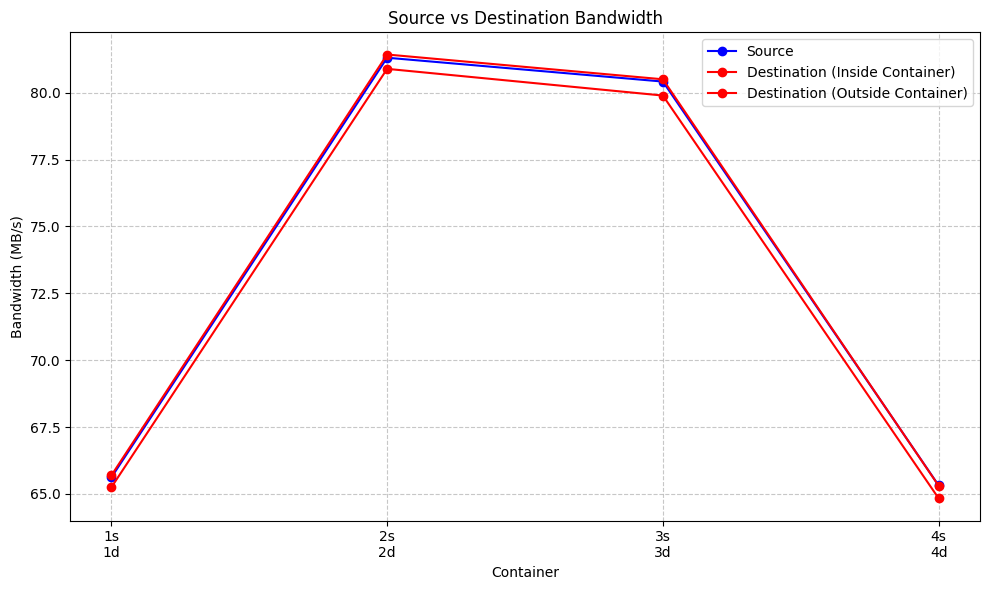

In [771]:
generate_traffic_heatmap(df_src_4, df_dst_4, "skb_egress")

Containers identified: ['2s', '4s', '6s', '5s', '8s', '1s', '3s', '7s']
Containers identified: ['1d', '2d', '7d', '5d', '6d', '4d', '8d', '3d']
{2: np.float64(71.50750097908916), 8: np.float64(66.51590786414637), 6: np.float64(71.84114504167106), 1: np.float64(71.83977826557673), 4: np.float64(68.58631276075944), 5: np.float64(70.55217017331746), 3: np.float64(66.97370202096774), 7: np.float64(66.73469416310081)}
{1: np.float64(25.437860250094307), 7: np.float64(27.891839977676955), 4: np.float64(26.400973004934208), 8: np.float64(26.9674005889492), 3: np.float64(26.63854774237031), 2: np.float64(25.778987949541865), 6: np.float64(25.74610201485356), 5: np.float64(25.74524899191661)}
{1: np.float64(71.37129486908107), 7: np.float64(66.75060276543257), 4: np.float64(68.64006439303229), 8: np.float64(66.84772563866494), 3: np.float64(67.26049059792005), 2: np.float64(70.63927282885417), 6: np.float64(71.15377935060171), 5: np.float64(70.37519032911162)}


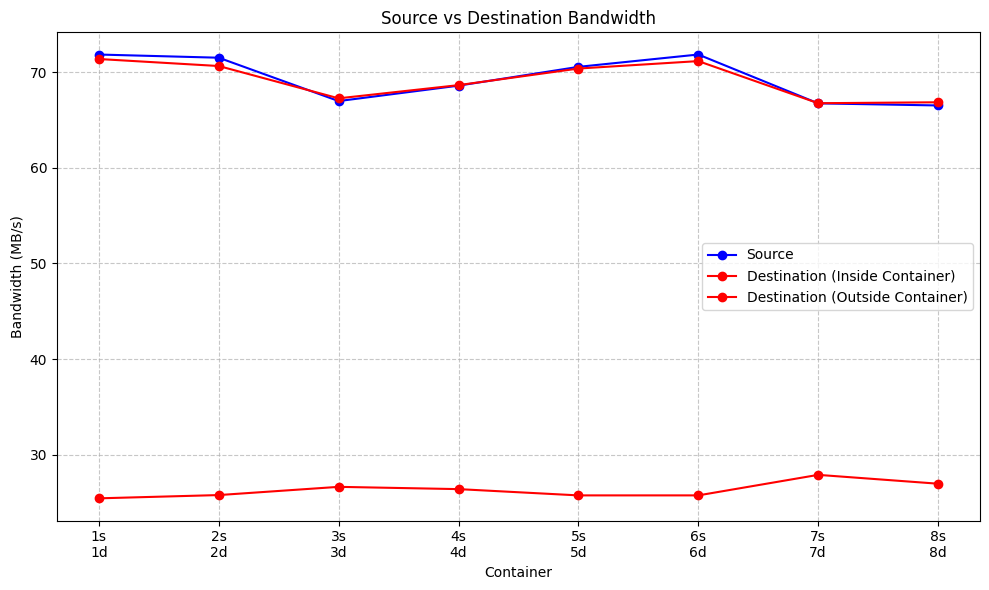

In [772]:
generate_traffic_heatmap(df_src_8, df_dst_8, "skb_egress")

Containers identified: ['16s', '2s', '14s', '4s', '6s', '10s', '5s', '8s', '15s', '12s', '13s', '1s', '3s', '9s', '7s', '11s']
Containers identified: ['14d', '12d', '1d', '2d', '7d', '6d', '5d', '11d', '16d', '15d', '13d', '10d', '4d', '8d', '9d', '3d']
{14: np.float64(62.22571639710631), 16: np.float64(63.72727107866036), 5: np.float64(61.32813922784854), 6: np.float64(61.19858584189186), 10: np.float64(64.29642024019054), 8: np.float64(61.46420881560997), 4: np.float64(62.95916822168729), 2: np.float64(62.37819927612607), 1: np.float64(60.16771151460759), 9: np.float64(64.12160672792085), 3: np.float64(65.90876221192724), 15: np.float64(63.50657336840791), 12: np.float64(63.665599380160494), 13: np.float64(61.50371234164881), 7: np.float64(59.66043621743168), 11: np.float64(63.88544517122974)}
{6: np.float64(22.546466466122105), 11: np.float64(20.10508569899768), 1: np.float64(21.167209504650618), 7: np.float64(22.572338768207374), 12: np.float64(33.543795537752814), 14: np.float64(2

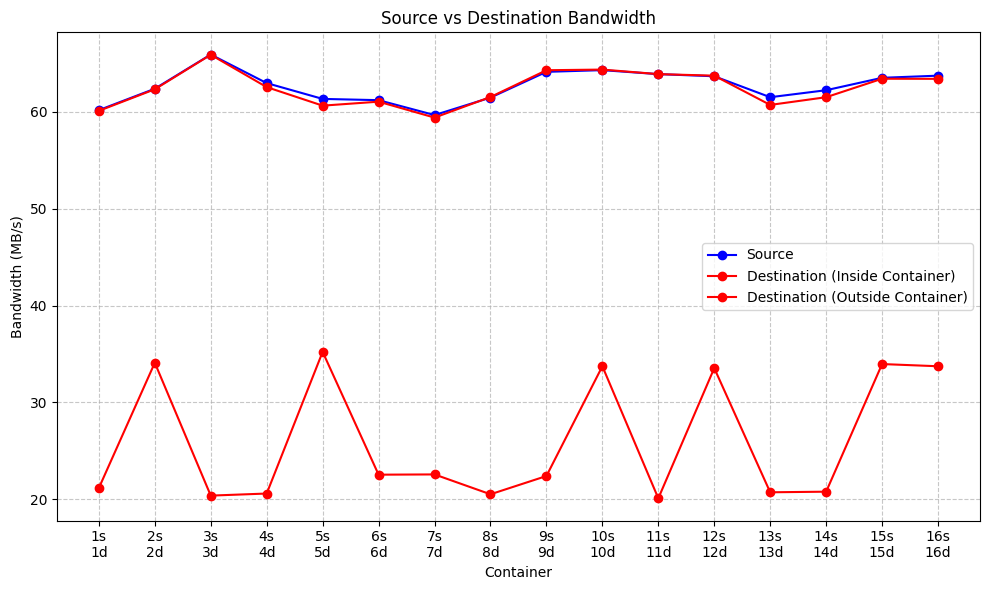

In [773]:
generate_traffic_heatmap(df_src_16, df_dst_16, "skb_egress")

In [852]:
generate_traffic_heatmap(df_src_64, df_dst_64, "skb_egress")

ValueError: cannot convert float NaN to integer

In [505]:
print_container_summary('2s', df_src)

container name = 2s

container:/_side (container:/2s)
* skb_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* skb_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_egress     79.53 MB/s (81,441.96 KB/s) - Total: 15,097,608 bytes

host:/_side (host:/2s)
* skb_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* skb_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_ingress    78.89 MB/s (80,783.45 KB/s) - Total: 14,974,500 bytes
* tc_ingress    79.60 MB/s (81,505.98 KB/s) - Total: 15,108,206 bytes
* tc_egress      0.00 MB/s (0.00 KB/s) - Total: 0 bytes


In [850]:
generate_traffic_heatmap(df_src_32, df_dst_32, "skb_egress")

ValueError: cannot convert float NaN to integer

In [506]:
print_container_summary('2d', df_dst)

container name = 2d

container:/_side (container:/2d)
* skb_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* skb_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_egress      0.00 MB/s (0.00 KB/s) - Total: 0 bytes

host:/_side (host:/2d)
* skb_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* skb_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_egress      0.00 MB/s (0.00 KB/s) - Total: 0 bytes


In [498]:
print_container_summary('boring_swanson', df)

container name = boring_swanson

container:/_side (container:/boring_swanson)
* skb_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* skb_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_egress      0.00 MB/s (0.00 KB/s) - Total: 0 bytes

host:/_side (host:/boring_swanson)
* skb_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* skb_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_egress      0.00 MB/s (0.00 KB/s) - Total: 0 bytes


In [270]:
print_container_summary('host_nic', df)

container name = host_nic
* skb_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* skb_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_egress    137.06 MB/s (140,344.43 KB/s) - Total: 30,267,888 bytes


# =============== DST ===============

In [271]:
import pandas as pd

# Load the CSV file
#df = pd.read_csv('data/intra/1_one_to_one_tcpreplay.csv')
df = pd.read_csv('data/inter/1_two_to_two_dst.csv')

# Set more readable display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [272]:
df["ContainerName"].unique()

array(['container:/trusting_jemison', 'container:/unruffled_davinci', nan,
       'host_lo', 'host:/unruffled_davinci', 'host:/trusting_jemison',
       'docker0', 'host_nic'], dtype=object)

In [273]:
print_container_summary('unruffled_davinci', df)

container name = unruffled_davinci

container:/_side (container:/unruffled_davinci)
* skb_egress    78.33 MB/s (80,208.38 KB/s) - Total: 14,356,500 bytes
* skb_ingress    78.33 MB/s (80,207.14 KB/s) - Total: 14,356,500 bytes
* xdp_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_ingress   130.55 MB/s (133,678.56 KB/s) - Total: 28,791,000 bytes
* tc_ingress   131.80 MB/s (134,960.81 KB/s) - Total: 29,059,716 bytes
* tc_egress      0.00 MB/s (0.00 KB/s) - Total: 0 bytes

host:/_side (host:/unruffled_davinci)
* skb_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* skb_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_egress    137.12 MB/s (140,407.90 KB/s) - Total: 30,254,262 bytes


In [274]:
print_container_summary('trusting_jemison', df)

container name = trusting_jemison

container:/_side (container:/trusting_jemison)
* skb_egress    67.47 MB/s (69,086.37 KB/s) - Total: 14,454,000 bytes
* skb_ingress    67.47 MB/s (69,086.12 KB/s) - Total: 14,454,000 bytes
* xdp_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_ingress   130.68 MB/s (133,814.87 KB/s) - Total: 28,779,000 bytes
* tc_ingress   131.99 MB/s (135,158.50 KB/s) - Total: 29,062,744 bytes
* tc_egress      0.00 MB/s (0.00 KB/s) - Total: 0 bytes

host:/_side (host:/trusting_jemison)
* skb_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* skb_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_egress    137.11 MB/s (140,400.96 KB/s) - Total: 30,251,234 bytes


In [671]:
print_container_summary('1s', df_src_8)

container name = 1s

container:/_side (container:/1s)
* skb_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* skb_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_egress     71.84 MB/s (73,563.93 KB/s) - Total: 15,109,720 bytes

host:/_side (host:/1s)
* skb_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* skb_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_ingress    71.18 MB/s (72,883.44 KB/s) - Total: 14,968,500 bytes
* tc_ingress    71.66 MB/s (73,380.84 KB/s) - Total: 15,070,356 bytes
* tc_egress      0.00 MB/s (0.00 KB/s) - Total: 0 bytes


In [65]:
print_container_summary('1s', df_src_8)

container name = 1s

container:/_side (container:/1s)
* skb_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* skb_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_egress     70.43 MB/s (72,121.44 KB/s) - Total: 1,507,944 bytes

host:/_side (host:/1s)
* skb_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* skb_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_ingress    70.80 MB/s (72,497.13 KB/s) - Total: 1,514,000 bytes
* tc_egress      0.00 MB/s (0.00 KB/s) - Total: 0 bytes


In [66]:
print_container_summary('2d', df_dst_8)

container name = 2d

container:/_side (container:/2d)
* skb_egress    70.73 MB/s (72,424.16 KB/s) - Total: 1,498,500 bytes
* skb_ingress    70.73 MB/s (72,424.77 KB/s) - Total: 1,498,500 bytes
* xdp_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_ingress    71.02 MB/s (72,724.01 KB/s) - Total: 1,504,916 bytes
* tc_egress      0.00 MB/s (0.00 KB/s) - Total: 0 bytes

host:/_side (host:/2d)
* skb_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* skb_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_egress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* xdp_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_ingress     0.00 MB/s (0.00 KB/s) - Total: 0 bytes
* tc_egress     71.33 MB/s (73,045.11 KB/s) - Total: 1,512,486 bytes
